# Flight Price Prediction #

## Introduction ##

Traveling by air is a common practice for many people around the globe, and the cost of air travel is a major factor in travel planning. For a given route, airfares can fluctuate significantly over time due to a variety of factors, such as demand, seasonality, and airline pricing strategies. This can lead to a common predicament for travelers: should they purchase their tickets now, or wait in the hopes of a price drop?

The aim of this project is to build a machine learning model that can help resolve this predicament. The model will predict whether it is optimal to purchase the ticket now or wait for a potential price drop.

The dataset used in this notebook is provided by Prof. Dr. Martin Spott and Manu Mutthatu.
It contains flight data from 2019 for the following routes:
-   London Stansted and Berlin Schönefeld
-   London Stansted and Frankfurt

This task is a practical application of machine learning that can provide valuable insights for both travelers and businesses in the travel industry. By predicting the optimal time to purchase a flight ticket, one can potentially save money and make travel planning less stressful. For businesses, this model can be used to build a buisness plan, to recommend the best time to purchase tickets to customers, or to optimize pricing strategies.

This notebook is organized as follows:
1. Load the data
2. Data Exploration and Feature Engineering
3. Data Preprocessing
4. Model Selection
5. Make Predictions

## Load the data ##

In this section, we will load the necessary Python libraries and the dataset we will be working with. This dataset, stored in a CSV file, is seperated in a train and a test dataset, each containing information about flight price requests. The test dataset is used to finally evaluate the performance of the model we will train on the train dataset. So in this notebook we will mostly use the train dataset and only use the test dataset to create a final prediction based on the trained model to see how well it performs compared to models trained by others.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
import sklearn
import xgboost as xgb

from datetime import date
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from pandas.plotting import scatter_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif 
from sklearn.feature_selection import mutual_info_regression 
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier



from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import learning_curve


pd.options.mode.chained_assignment = None

In [2]:
# read in the data
df_train = pd.read_csv('train_set.csv')
df_test = pd.read_csv('test_set.csv')

## Data Exploration and Feature Engineering ##

**Data Exploration** <br>
is the first step in this workflow we delve into the dataset to understand the relationships and trends between different features. This phase is crucial as it provides insights into the data, which can guide our model training later. We will perform several tasks, including:

- Reviewing the first rows of the dataset for a general overview
- Investigating the data types of each feature to comprehend the nature of data we are dealing with
- Checking for duplicate and missing values and considering strategies to handle them
- Computing basic statistical metrics (mean, standard deviation, quartiles) to understand the distribution of data
- Dig deeper into the data by plotting histograms and other charts for each feature to provide visual insights
- Investigating the correlations among features. This will help us understand if some features are redundant due to high correlations with other features or if some features are highly correlated with the target variable and can be used to predict it


**Feature Engineering** <br> 
 involves creating new features from the existing data to improve the predictive power of the model. This might involve transforming, combining, deriving, or otherwise manipulating data to better utilize the information they hold. 
 For instance, it might be useful to extract the day of the week from the flight date, as weekend flights might be pricier than weekday flights. 
 Additionally, a strategy to handle categorical features is required, as most machine learning algorithms can only handle numerical data.


### Get to know the data ###

In [3]:
# make a copy of the data
df_train_copy = df_train.copy()
df_test_copy = df_test.copy()

# check the data
df_train_copy.head()

,index,Request_Date,Flight_Date,Departure_hour,flight_unique_id,route_abb,Price_In_Eur,min_future_price_in_Eur,buy
0,1,2019-06-03T11:00:00Z,2019-06-05,19,2019-06-05 FR 146,SXF-STN,208.07,259.07,1
1,2,2019-06-03T23:00:00Z,2019-06-05,19,2019-06-05 FR 146,SXF-STN,259.07,259.07,1
2,3,2019-06-04T11:00:00Z,2019-06-05,19,2019-06-05 FR 146,SXF-STN,259.07,259.07,1
3,4,2019-06-04T23:00:00Z,2019-06-05,19,2019-06-05 FR 146,SXF-STN,259.07,259.07,1
4,5,2019-06-03T11:00:00Z,2019-06-05,21,2019-06-05 FR 147,STN-SXF,143.86,251.72,1


The data contains the following columns:
-   *index*: index of the row
-   *request_date*: date when the request was made
-   *flight_date*: date when the flight took place
-   *departure_hour*: hour when the flight departed
-   *flight_unique_id*: unique id for each flight
-   *route_abb*: abbreviation of the route
-   *price_in_eur*: price of the flight in euro
-   *min_future_price_in_euro*: minimum price of the flight in euro for all future request dates
-   *buy*: 1 if the flight should now be bought, 0 if one should wait

In [4]:
# check the number of rows and columns
df_train_copy.shape

(83624, 9)

The data contains 83624 rows and 9 columns.

In [5]:
# check the data types
df_train_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83624 entries, 0 to 83623
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   index                    83624 non-null  int64  
 1   Request_Date             83624 non-null  object 
 2   Flight_Date              83624 non-null  object 
 3   Departure_hour           83624 non-null  int64  
 4   flight_unique_id         83624 non-null  object 
 5   route_abb                83624 non-null  object 
 6   Price_In_Eur             83624 non-null  float64
 7   min_future_price_in_Eur  83624 non-null  float64
 8   buy                      83624 non-null  int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 5.7+ MB


The data types are correct, except for the date columns. We will deal with that later.

In [6]:
# check if there are any missing values
df_train_copy.isnull().sum()

index                      0
Request_Date               0
Flight_Date                0
Departure_hour             0
flight_unique_id           0
route_abb                  0
Price_In_Eur               0
min_future_price_in_Eur    0
buy                        0
dtype: int64

Luckily, there are no missing values in the data.

In [7]:
# check for duplicates
df_train_copy.duplicated().sum()

0

There are no duplicates in the data.

Next, we will search for outliers in the data. Therefore we look at the z-score of each value in the data. The z-score is the number of standard deviations away from the mean a data point is. We will remove all data points that have a z-score bigger them 3, because these are considered as outliers, because the standard deviation differ too much from the mean.

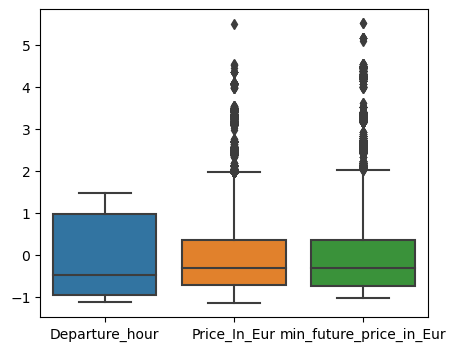

In [8]:
## Get the z-scores and create boxplots for the numerical columns

# Calculate z-scores for the numerical columns
df_train_num = df_train_copy[['Departure_hour', 'Price_In_Eur', 'min_future_price_in_Eur']]
z_scores_train = stats.zscore(df_train_num)

# Calculate z-scores for the numerical columns
z_scores_test = stats.zscore(df_train_num[['Departure_hour', 'Price_In_Eur', 'min_future_price_in_Eur']])

# Create Boxplots for the z-scores
plt.figure(figsize=(5, 4))
sns.boxplot(data=z_scores_train);

In [9]:
## Get the data considered as outliers

# Get the rows with z-scores > 3
outliers_train = np.where(z_scores_train > 3)

# Get the rows in the df_train_copy that contain outliers
df_train_copy_outlier_rows = df_train_copy.iloc[outliers_train[0]]

# Check the proportion of outliers
print(len(df_train_copy_outlier_rows)/len(df_train_copy))

0.04889744570936573


There are around 4.9% outliers in the data. Before we remove or transform them, we need to check if the outliers are reasonable or not. If they are reasonable, we can keep them. If they are not reasonable, we can remove them or transform them. Therefore we look at some features and their relationship with the outliers.

In [10]:
# Check the distribution of the route_abb column for the outliers
df_train_copy_outlier_rows['route_abb'].value_counts()

STN-SXF    1899
SXF-STN    1479
STN-FRA     393
FRA-STN     318
Name: route_abb, dtype: int64

In [11]:
# Check the distribution of Departure_hour column for the outliers
df_train_copy_outlier_rows['Departure_hour'].value_counts()

19    1247
6      767
18     667
7      666
10     349
22     285
8       68
21      40
Name: Departure_hour, dtype: int64

It seems that the outliers are not random but are associated with specific routes and departure hours. This suggests that they might be extreme but valid data points. Therefore we will not remove or replace them.

In [12]:
# check the noise in the data
df_train_copy.describe()

,index,Departure_hour,Price_In_Eur,min_future_price_in_Eur,buy
count,83624.000000,83624.000000,83624.000000,83624.000000,83624.000000
mean,41812.500000,12.969889,71.965080,56.593014,0.223835
std,24140.313792,6.177936,54.788483,46.126909,0.416815
min,1.000000,6.000000,8.990000,8.990000,0.000000
25%,20906.750000,7.000000,32.770000,22.270000,0.000000
50%,41812.500000,10.000000,55.080000,41.890000,0.000000
75%,62718.250000,19.000000,91.790000,73.430000,0.000000
max,83624.000000,22.000000,372.960000,311.090000,1.000000


-  Departure_hour: earliest departure hour is 6 (6 am), latest departure hour is 22 (10pm). Mean is 13 (1 pm).
-  Price_In_Eur: minimum price is 8.99€, maximum price is 372.96€. Average price is 72€.
-  Min_future_price_in_euro: minimum minimum future price is 8.99€, maximum minimum future price is 311.09€. Average minimum future price is 57€.
-  Buy: is a boolean value. Therefore the description is not very meaningful except we can see, that more flights in the data were recommended to wait than to buy.

Now we want to dig deeper into the data and see if we can find any interesting insights that we can use to improve our model. Therefore we will have a look at each feature. Those include:   
- *Price_In_Eur*             
- *min_future_price_in_Eur*  
- *Request_Date*               
- *Flight_Date*                
- *Departure_hour*             
- *route_abb*                 
- *buy*                  
- *flight_unique_id*                 

### Price in Eur ###

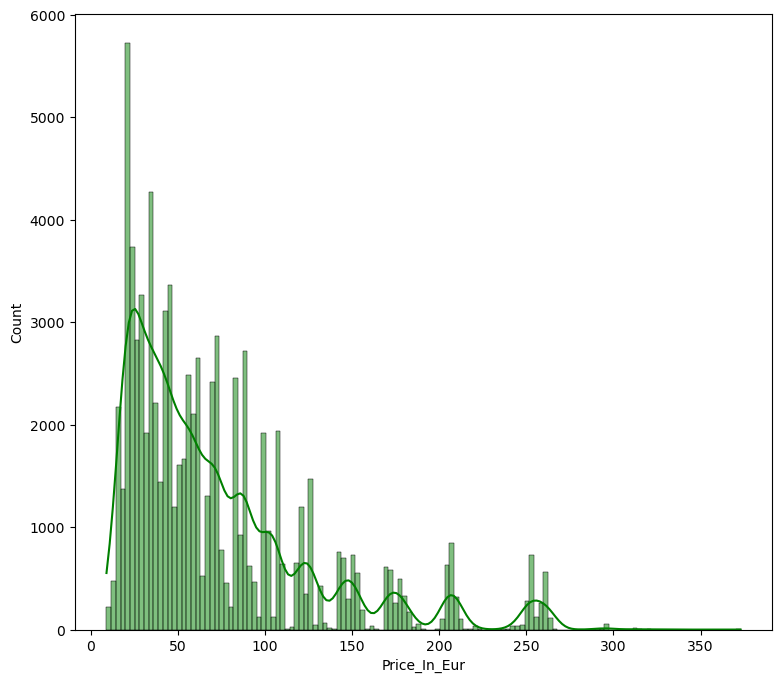

In [13]:
# check the distribution of Price in Euro
plt.figure(figsize=(9, 8))
sns.histplot(df_train_copy['Price_In_Eur'], color='g', kde=True);

The prices seem to be quite evenly distributed. There are fluctuations in the higher prices that seem to be repeated. Also there seems to be some more expensive flights in prices around and above 350€.

### Min Future Price in Euro ###

*min_future_price_in_Eur* is a useful target variable for our model, if we want to make a regression model, because if this value is less then the current price, then we can say that it might be better to wait to buy the ticket. If this value is greater then the current price, then we can say that it might be better to buy the ticket now.

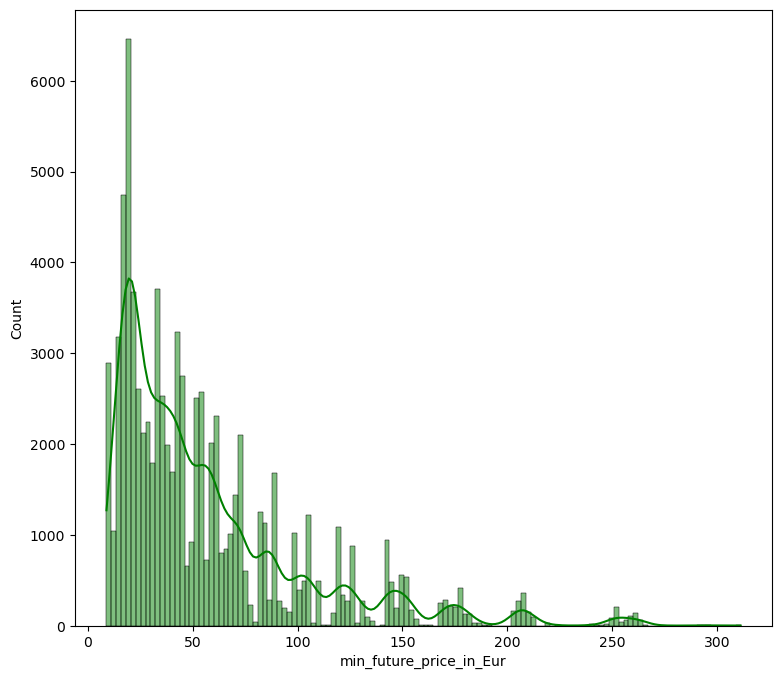

In [14]:
# check distribution of min_future_price_in_eur
plt.figure(figsize=(9, 8))
sns.histplot(df_train_copy['min_future_price_in_Eur'], color='g', kde=True);

The min_future_price_in_Eur distribution nearly looks exactly like the Price_in_Eur distribution. This is as expected, since the min_future_price_in_Eur is the minimum price (Price_In_Eur) of the flight in the future. 

### Request Date ###

We already have seen, that Request_Date is of type object. Therefore we need to convert it to datetime format so that we can extract information like day or month from it.

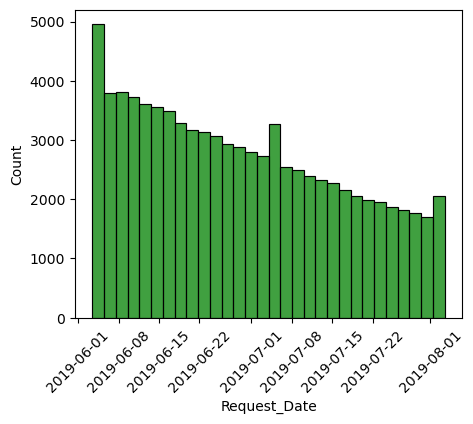

In [15]:
# check the distribution of the request date
# convert the request date to datetime
df_train_copy['Request_Date'] = pd.to_datetime(df_train_copy['Request_Date'])

plt.figure(figsize=(5, 4))
sns.histplot(df_train_copy['Request_Date'], color='g', bins=30);

# rotate the x axis value description to make it more readable
plt.xticks(rotation=45);


In [16]:
# check the last date in the data
print(df_train_copy['Request_Date'].min())
print(df_train_copy['Request_Date'].max())

2019-06-03 11:00:00+00:00
2019-08-03 11:00:00+00:00


The data contains requests from 2019-06-03 to 2019-08-03.

Maybe it is useful for the model to know in which month the flight is taking place. So we will add a new column called *Request_Month* to the dataframe.

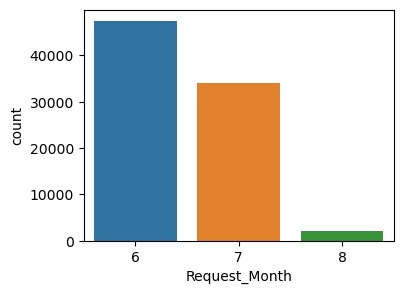

In [17]:
# Extract the month from the request date
df_train_copy['Request_Month'] = df_train_copy['Request_Date'].dt.month

# plot the request month
plt.figure(figsize=(4,3))
sns.countplot(x='Request_Month', data=df_train_copy);

The data only contains requests of the months 6, 7 and 8, meaning June, July and August. The Month with the most requests is June, a little less in July and only a few in August.

Additionally it may be interesting to know, on which day of the week the request was made. This can be done by extracting the day of the week from the date of the request, we call this feature *Request_Day_Of_Week*. The day of the week is encoded as a number between 0 and 6, where 0 is Monday and 6 is Sunday.

<AxesSubplot:xlabel='Request_Day_Of_Week', ylabel='count'>

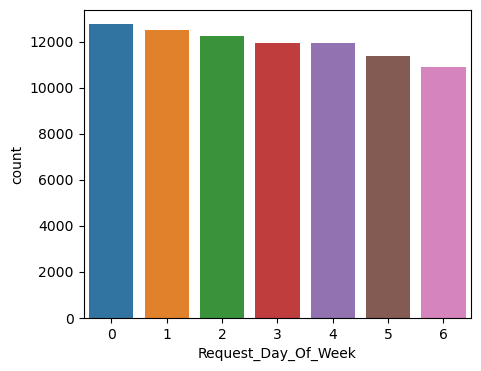

In [18]:
# Extract the day of the week from the request date
df_train_copy['Request_Day_Of_Week'] = df_train_copy['Request_Date'].dt.dayofweek
# 0 = Monday, 6 = Sunday

# plot the request day of the week
plt.figure(figsize=(5, 4))
sns.countplot(x='Request_Day_Of_Week', data=df_train_copy)

There are nearly the same amount of requests on each day of the week.

Maybe it is interesting to know if the request was made on a weekend or not. So we will create a new feature called *Request_is_Weekend* which will be 1 if the request was made on a weekend and 0 if it was made on a weekday.

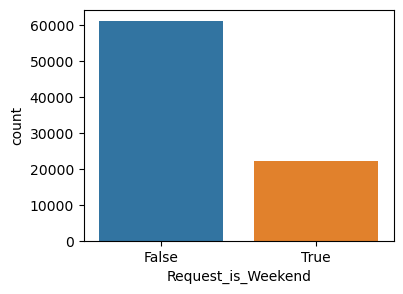

In [19]:
# create a new column to indicate if the request was made on a weekend
df_train_copy['Request_is_Weekend'] = df_train_copy['Request_Date'].dt.weekday >= 5

# plot the request is weekend
plt.figure(figsize=(4,3))
sns.countplot(x='Request_is_Weekend', data=df_train_copy);

The Request_Date contains information regarding the time in which the request was made. With this information, we can create a new feature called "Request_Hour" which will contain the hour of the day in which the request was made.

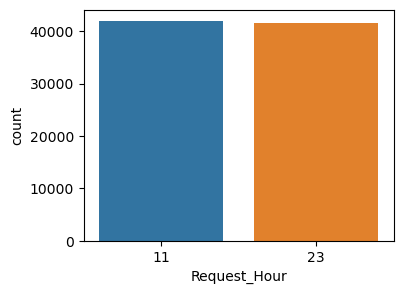

In [20]:
# extract the hour from the request date
df_train_copy['Request_Hour'] = df_train_copy['Request_Date'].dt.hour

# plot the request hour
plt.figure(figsize=(4,3))
sns.countplot(x='Request_Hour', data=df_train_copy);

There were requests only at 11 (11 am) and at 23 (11 pm).

### Flight Date ###

Just like the Request_Date column the Flight_Date column is also from type object. We need to convert it to datetime format.

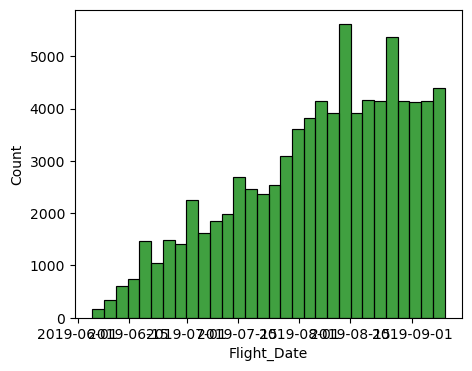

In [21]:
# check the distribution of flight date
# convert the flight date to datetime
df_train_copy['Flight_Date'] = pd.to_datetime(df_train_copy['Flight_Date'])

plt.figure(figsize=(5,4))
sns.histplot(df_train_copy['Flight_Date'], color='g', bins=30);

In [22]:
# get the first and the last flight date
print(df_train_copy['Flight_Date'].min())
print(df_train_copy['Flight_Date'].max())

2019-06-05 00:00:00
2019-09-10 00:00:00


The first flight left on 2019-06-05 and the last flight on 2019-09-10.

Like with Request_Date, we extract information to get the Flight Month.

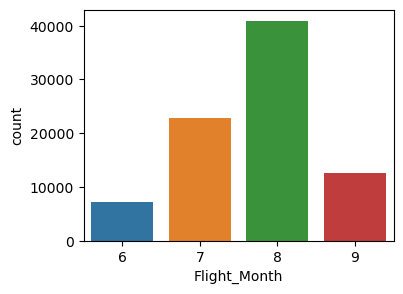

In [23]:
# Extract the month from the flight date
df_train_copy['Flight_Month'] = df_train_copy['Flight_Date'].dt.month

# plot the flight month
plt.figure(figsize=(4,3))
sns.countplot(x='Flight_Month', data=df_train_copy);

Most flights depart in August, around half as many in July and only a few in September and even less in June.

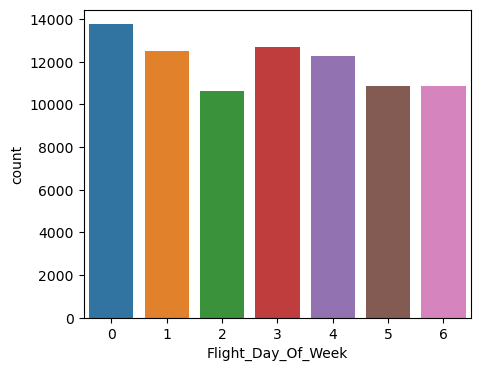

In [24]:
# Extract the day of the week from the flight date
df_train_copy['Flight_Day_Of_Week'] = df_train_copy['Flight_Date'].dt.dayofweek
# 0 = Monday, 6 = Sunday

# plot the flight day of the week
plt.figure(figsize=(5,4))
sns.countplot(x='Flight_Day_Of_Week', data=df_train_copy);

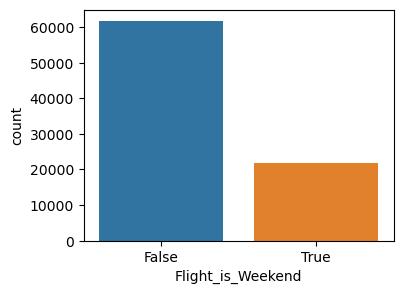

In [25]:
# create a new column to indicate if the flights are on a weekend
df_train_copy['Flight_is_Weekend'] = df_train_copy['Flight_Date'].dt.weekday >= 5

# plot the request is weekend
plt.figure(figsize=(4,3))
sns.countplot(x='Flight_is_Weekend', data=df_train_copy);

In [26]:
# check data types of flight date and request date
print(df_train_copy['Flight_Date'].dtype)
print(df_train_copy['Request_Date'].dtype)

# remove the timezone from the request date
df_train_copy['Request_Date'] = df_train_copy['Request_Date'].dt.tz_convert(None)

# check dates, where the flight date is before the request date
flight_date_before_request_date = df_train_copy[df_train_copy['Flight_Date'] < df_train_copy['Request_Date']]

print(flight_date_before_request_date.shape[0])

datetime64[ns]
datetime64[ns, UTC]
0


There are no Flights where the flight date is before the request date.

### New Feature: Days between request date and flight date ###

count    83624.000000
mean        37.913601
std         22.859873
min          0.000000
25%         19.000000
50%         36.000000
75%         55.000000
max         98.000000
Name: days_between_request_and_flight, dtype: float64


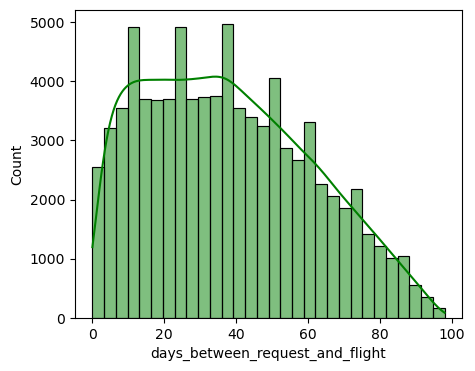

In [27]:
# check the distribution of the number of days between request date and flight date
df_train_copy['days_between_request_and_flight'] = (df_train_copy['Flight_Date'] - df_train_copy['Request_Date']).dt.days

plt.figure(figsize=(5,4))
sns.histplot(df_train_copy['days_between_request_and_flight'], color='g', kde=True, bins=30);

# get the min, max, mean and median of the number of days between request date and flight date
print(df_train_copy['days_between_request_and_flight'].describe())

There are between 0 and 98 days between the request date and the flight date.

### Departure Hour ###

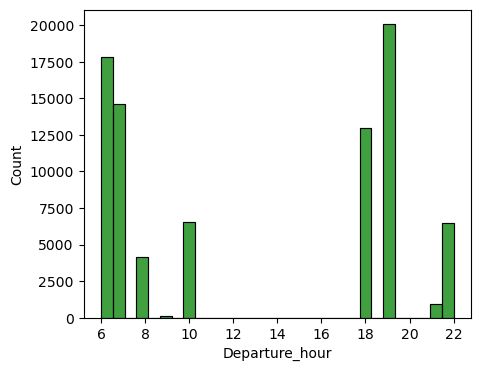

In [28]:
# check the distribution of Departure hour
plt.figure(figsize=(5,4))
sns.histplot(df_train_copy['Departure_hour'], color='g');

In [29]:
# check the amounts of data with Departure hour between 12 and 16
df_train_copy[(df_train_copy['Departure_hour'] >= 12) & (df_train_copy['Departure_hour'] <= 16)].shape[0]

0

The earliest flights depart at 6, the latest at 22. Most flights seem to depart in the morning or in the evening. There are no flights departing in the afternoon between 12 and 16.

### New Feature: Is Holiday ###

As it is possible that the price of flights is higher on bank holidays or during school holidays, a new feature is added to the data: is_holiday. 

#### Bank Holidays ####

The data for the bank holidays is taken from the python package holidays. The data contains bank holidays for different countries. The data for holidays in germany and uk is then merged with the data from the flights.

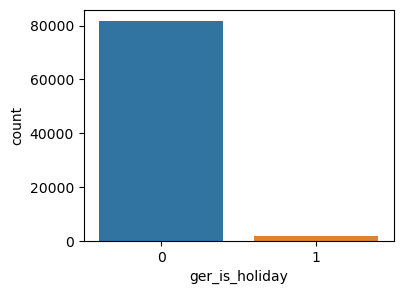

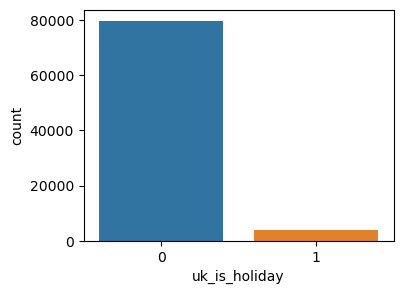

In [30]:
import holidays

ger_holidays = holidays.GR()
# create a function to check if a date is a holiday in germany
def is_holiday_ger(date):
    if date in ger_holidays:
        return 1
    else:
        return 0
    
# create a new column with the holiday information
df_train_copy['ger_is_holiday'] = df_train_copy['Flight_Date'].apply(is_holiday_ger)

# check the distribution of is_holiday
plt.figure(figsize=(4,3)) 
sns.countplot(x='ger_is_holiday', data=df_train_copy);


uk_holidays = holidays.UK()
# create a function to check if a date is a holiday in the UK
def is_holiday_uk(date):
    if date in uk_holidays:
        return 1
    else:
        return 0

# create a new column with the holiday information
df_train_copy['uk_is_holiday'] = df_train_copy['Flight_Date'].apply(is_holiday_uk)

# check the distribution of is_holiday
plt.figure(figsize=(4,3))
sns.countplot(x='uk_is_holiday', data=df_train_copy);

Because there are only a few holidays in the data, the two holiday columns are combined to one column. The new column contains the information if the flight is on a holiday (it doesn't matter if in the departure or arrival country) or not.

In [31]:
# define a function to check if a date is a holiday in the UK or Germany
def is_holiday_uk_ger(date):
    if date in ger_holidays or date in uk_holidays:
        return 1
    else:
        return 0

In [32]:
# merge the two holiday columns into one
df_train_copy['is_bank_holiday'] = df_train_copy['ger_is_holiday'] + df_train_copy['uk_is_holiday']

# drop the two seperate bank holiday columns for ger and uk
df_train_copy.drop(['ger_is_holiday', 'uk_is_holiday'], axis=1, inplace=True)

#### School holidays ####

Flight prices may be higher during the school holidays, because more people have the opportunity to go on vacation. Because the flights arrival and departure airports are in Germany and UK, the school holidays for these countries are added to the data [1, 2]. Because in Germany the school holidays are different for each state, the school holidays for the state of the departure airport are added to the data, meaning Berlin (and Brandenburg because it is close to Berlin) and Nordrhein-Westfalen (NRW). Only if the flight is in the school holidays of the departure or arrival airport, the flight is marked as a flight during the school holidays.

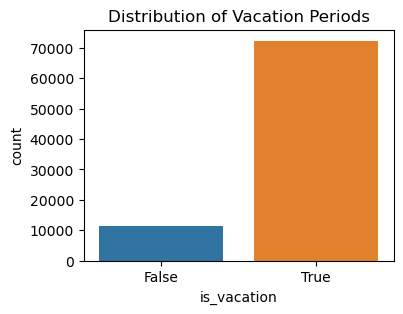

In [33]:
# add school holidays of NRW, Berlin, Brandenburg and UK
# Define the vacation periods with associated airports
vacations = [
    {'start': '2019-07-15', 'end': '2019-08-27', 'airports': ['FRA']},  # NRW
    {'start': '2019-05-31', 'end': '2019-06-11', 'airports': ['SXF']},  # Berlin
    {'start': '2019-06-20', 'end': '2019-08-02', 'airports': ['SXF']},  # Berlin
    {'start': '2019-06-20', 'end': '2019-08-03', 'airports': ['SXF']},  # Brandenburg
    {'start': '2019-07-15', 'end': '2019-09-06', 'airports': ['STN']}   # UK
]

# Convert the start and end dates to datetime
for vacation in vacations:
    vacation['start'] = pd.to_datetime(vacation['start'])
    vacation['end'] = pd.to_datetime(vacation['end'])

# Extract the Departure_airport and Arrival_airport from the route_abb column
df_train_copy['departure_airport'] = df_train_copy['route_abb'].str[:3]
df_train_copy['arrival_airport'] = df_train_copy['route_abb'].str[-3:]

# Initialize a new column 'is_vacation' with False
df_train_copy['is_vacation'] = False

# Set 'is_vacation' to True if the flight date is within any of the vacation periods and the origin or destination airport is associated with the vacation
for vacation in vacations:
    df_train_copy.loc[(df_train_copy['Flight_Date'] >= vacation['start']) & (df_train_copy['Flight_Date'] <= vacation['end']) & ((df_train_copy['departure_airport'].isin(vacation['airports'])) | (df_train_copy['arrival_airport'].isin(vacation['airports']))), 'is_vacation'] = True

# Display the first few rows of the dataframe
df_train_copy.head()

# drop the departure and arrival airport columns
df_train_copy.drop(['departure_airport', 'arrival_airport'], axis=1, inplace=True)

# plot the distribution of is_vacation
plt.figure(figsize=(4, 3))
sns.countplot(x='is_vacation', data=df_train_copy)
plt.title('Distribution of Vacation Periods')
plt.show()

There seems to be a lot more requests for flights during the vacation periods. This is probably because people are more likely to travel during the vacation periods and the date ranges only for the months July till September, which is in most countries the vacation period.

#### Merge bank holidays and school holidays ####

Because bank holidays and school holidays are sematically similar, we combine them into one feature *is_holiday* and drop the other two seperate features.

In [34]:
# merge the columns 'is_holiday' and 'is_vacation' into one column
df_train_copy['is_holiday'] = df_train_copy['is_bank_holiday'] | df_train_copy['is_vacation']

# drop the column 'is_vacation'
df_train_copy.drop('is_vacation', axis=1, inplace=True)
# drop the column 'is_bank_holiday'
df_train_copy.drop('is_bank_holiday', axis=1, inplace=True)

### Route Abb ###

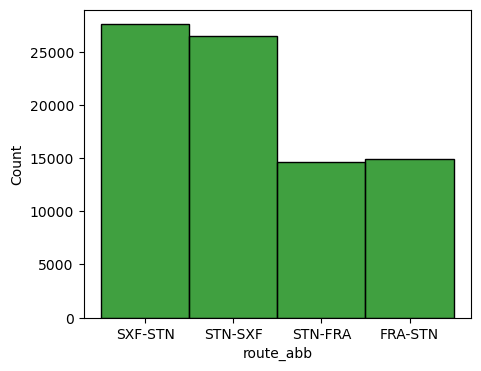

In [35]:
# check the distribution of route abb
plt.figure(figsize=(5, 4))
sns.histplot(df_train_copy['route_abb'], color='g');

The data contains 2 routes: SXF-STN and STN-FRA additionally for both of those routes there are flights in both directions. There are a little more than 10000 more flights from STN-SXF/SXF-STN than from FRA-STN/STN-FRA.

It may be helpful to extract the departure and arrival airport from the route and create a new feature for it, so we can later see if the airport has an impact on the buy decision
.

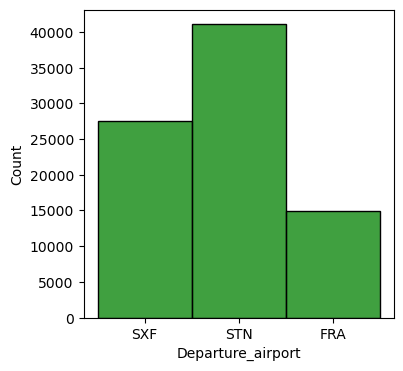

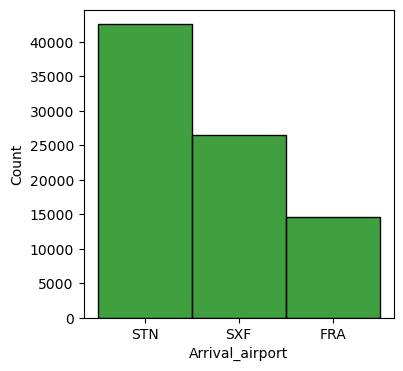

In [36]:
# Extract the departure and arrival airports from the route_abb column
df_train_copy['Departure_airport'] = df_train_copy['route_abb'].str.split('-').str[0]
df_train_copy['Arrival_airport'] = df_train_copy['route_abb'].str.split('-').str[1]

# check the distribution of Departure airport
plt.figure(figsize=(4, 4))
sns.histplot(df_train_copy['Departure_airport'], color='g');

# check the distribution of Arrival airport
plt.figure(figsize=(4, 4))
sns.histplot(df_train_copy['Arrival_airport'], color='g');

Most flights seem to depart from or arrive at STN. The least common airport is FRA.

### Buy ###

The *buy* column is calculated with the columns *Price_In_Eur* and *min_future_price_in_Eur*. If the *min_future_price_in_Eur* is lower than the *Price_In_Eur* the *buy* column is set to 1, otherwise to 0. This means it is a good target variable for a classification problem.

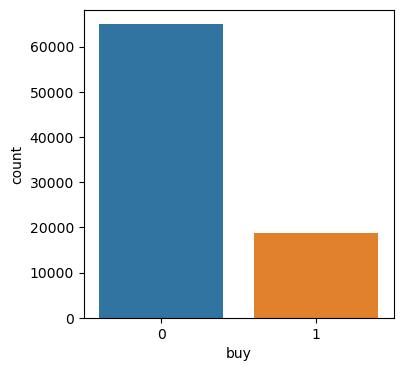

In [37]:
# check the distribution of buy
plt.figure(figsize=(4, 4))
sns.countplot(x='buy', data=df_train_copy);

There are more than three times more requests where the flight is currently not recommended to be bought than requests where the flight is recommended to be bought.

### Flight Unique Id ###

Maybe the number of requests recently made for each flight (flight_unique_id) is a good indicator to tell, if the price is going to increase or decrease. It could be that the price of an highly requestd flight is going up or down. Let's find out.

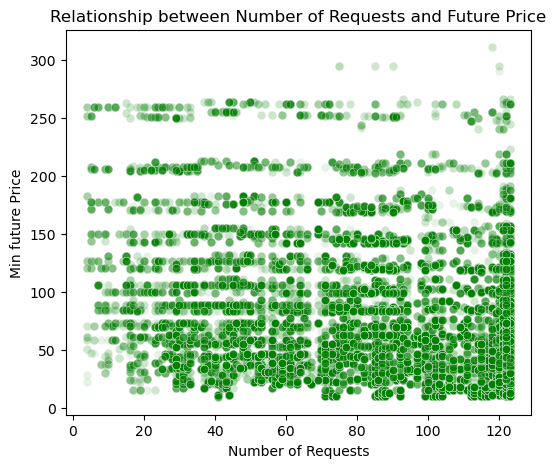

In [38]:
# check the number of requests for each flight
df_train_copy['num_requests'] = df_train_copy['flight_unique_id'].map(df_train_copy['flight_unique_id'].value_counts())

# plot the relationship between number of requests and price
plt.figure(figsize=(6, 5))
sns.scatterplot(data=df_train_copy, x='num_requests', y='min_future_price_in_Eur', alpha=0.1, color='g')
plt.title('Relationship between Number of Requests and Future Price')
plt.xlabel('Number of Requests')
plt.ylabel('Min future Price')
plt.show()

For some flights there seem to be a lot more requests than for others. It seems that the future price of a few flights that are relatively often requested is higher than from not so often requested flights. We investigate this correlation later on in this notebook when we look at the feature importance.

We can't use this feature for training, because it contains data, we don't have in practise. Therefore we will newly calculate the number of requests by using the rolling function to calculate the number of requests in the last 5 days.

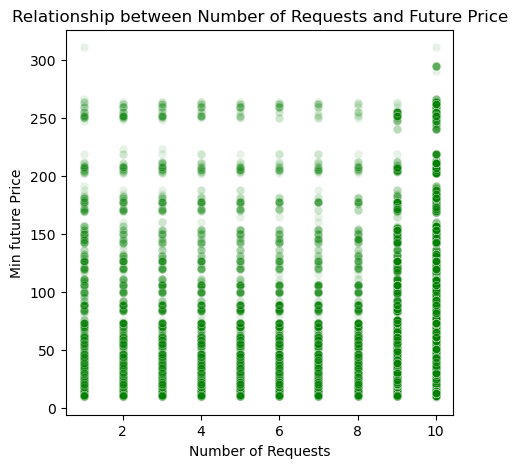

In [39]:
def rolling_num_requests():
    # Sort the data by Flight_Date
    df = df_train_copy.sort_values('Request_Date')

    # Calculate the number of requests in the last 5 days for each flight
    df_train_copy['num_requests'] = df_train_copy.groupby('flight_unique_id').rolling('5D', on='Request_Date')['Request_Date'].count().reset_index(drop=True)

    # Replace NaN values with the mean of the rest of the values in the column
    df_train_copy['num_requests'].fillna(df_train_copy['num_requests'].mean(), inplace=True)

rolling_num_requests()
# Plot the relationship between number of requests and price
plt.figure(figsize=(5, 5))
sns.scatterplot(data=df_train_copy, x='num_requests', y='min_future_price_in_Eur', alpha=0.1, color='g')
plt.title('Relationship between Number of Requests and Future Price')
plt.xlabel('Number of Requests')
plt.ylabel('Min future Price')
plt.show()


### New Feature: Current Price Trend ###

The current price trend may be a relevant information. If the price is currently rising, it may be better to buy the flight now. If the price is currently falling, it may be better to wait a little longer. Therefore we calculate the rolling average of the price for the last 5 requests. Then we compare the rolling mean with the rolling mean contained in the data of the current request. This allows us to determine how much the price is currently rising or falling.

In [40]:
# function to calculate the current price trend
def price_trend():
    
    # Calculate the rolling mean of the price with a window size of 5
    df_train_copy['rolling_mean_price'] = df_train_copy.groupby('flight_unique_id')['Price_In_Eur'].transform(lambda x: x.rolling(5, 1).mean())

    # Calculate the price trend as the difference between the current and previous rolling mean price
    df_train_copy['price_trend'] = df_train_copy.groupby('flight_unique_id')['rolling_mean_price'].transform(lambda x: x.diff())

    # replace the NaN values in the 'price_trend' column with 0
    df_train_copy['price_trend'] = df_train_copy['price_trend'].fillna(0)
        
    # drop 'rolling_mean_price'
    df_train_copy.drop(['rolling_mean_price'], axis=1, inplace=True)

price_trend()

Now we can look at the price trends over the time for the flights.

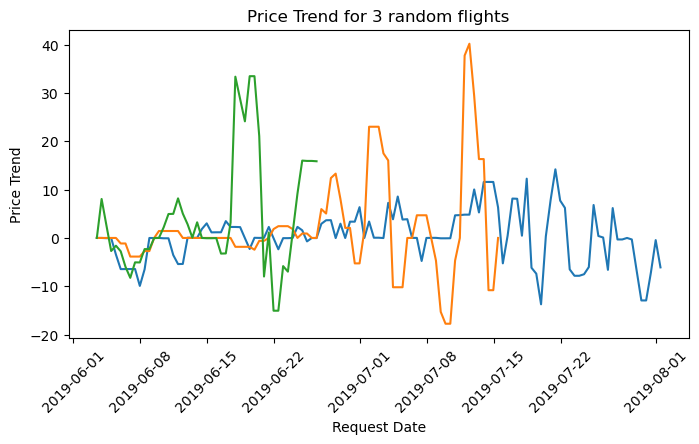

In [41]:
flight_ids = df_train_copy['flight_unique_id'].sample(3).values

plt.figure(figsize=(8, 4))

# Plot the price trend for each flight request
for flight_id in flight_ids:
    plt.plot(df_train_copy[df_train_copy['flight_unique_id'] == flight_id]['Request_Date'], 
             df_train_copy[df_train_copy['flight_unique_id'] == flight_id]['price_trend'])
plt.title(f'Price Trend for 3 random flights')
plt.xlabel('Request Date')
plt.ylabel('Price Trend')
plt.xticks(rotation=45)
plt.show()

### Summary ###

The data exploration so far showed that:
-  There are no duplicates in the data
-  There are no missing values in the data
-  *Request_date* and *Flight_date* are of type object, but should be of type datetime. Request date contained the timezone information, which was removed. The data was then converted to datetime.
-  *Price_In_Eur*:
    -  The distribution is right-skewed, with most of the flight prices being less than 100 EUR. There are also some flights with prices up to around 375 EUR, but these are less common.
-  *Min_future_price_in_Eur*:
    -  The distribution is similar to that of 'Price_In_Eur', being right-skewed with most of the minimum future prices being less than 100 EUR. There are also some flights with minimum future prices up to around 300 EUR, but these are less common.
-  *Request_Date*:
    -  the data contains *Request_date*s from 2019-06-03 to 2019-08-03. There are no outliers. <br>
    The data only contains requests of the months 6, 7 and 8, meaning June, July and August. The Month with the most requests is June, a little less in July and only a few in August. <br>
    There are nearly the same amount of requests on each day of the week. There are no outliers.
-  *Flight_Date*:
    -  the first *Flight_date* is on 2019-06-05 and the last flight on 2019-09-10. There are no outliers.
-  *Departure_hour*:
    -  the flights depart between 6 and 22, most of them in the morning or in the evening, none between 12 and 16. There are no outliers.
-  *Route_abb*:
    -  the data contains 2 routes in *route_abb* with flights in both directions, so 4 routes: SXF-STN and STN-FRA. There are around 1.5 times more flights from STN-SXF/SXF-STN than from FRA-STN/STN-FRA. There are no outliers.
-  *Buy*:
    -  there are more than three times more flights that currently are recommended not to *buy* than flights that should be bought.
-  *Flight_unique_id*:
    -  the distribution of the number of requests per flight shows that a small number of flights account for a disproportionately high share of total requests, while the majority of flights receive only a small number of requests.

Additionally, we added some new features:
-  *Request_Month*
-  *Request_Day_Of_Week*
-  *Request_Hour*
-  *Request_is_Weekend*
-  *Flight_Month*
-  *Flight_Day_Of_Week*
-  *Flight_is_Weekend*
-  *days_between_request_and_flight*
-  *is_holiday*
-  *Departure_airport*
-  *Arrival_airport*
-  *num_requests*
-  *price_trend*

Let's have a look at how important the features are for predicting the buy-decision.

### Looking for Correlations ###

Because *min_future_price_in_eur* or *buy* can be used as the target variables, we will especially check for correlation between them and the other variables.

#### Numerical Features ####

First we get a quick overview of the correlations between the numerical features and the target variable by using the corr() method. We will further look at the correlation between the features in the following steps.

In [42]:
df_train_copy_num = df_train_copy[['Price_In_Eur', 'price_trend', 'days_between_request_and_flight', 'num_requests', 'buy', 'min_future_price_in_Eur']]

In [43]:
# check the correlation between the quantitative features and the target variable 'buy'
corr_matrix = df_train_copy_num.corr()
corr_matrix['buy'].sort_values(ascending=False)

buy                                1.000000
min_future_price_in_Eur            0.197882
num_requests                      -0.002273
Price_In_Eur                      -0.038199
price_trend                       -0.105969
days_between_request_and_flight   -0.224999
Name: buy, dtype: float64

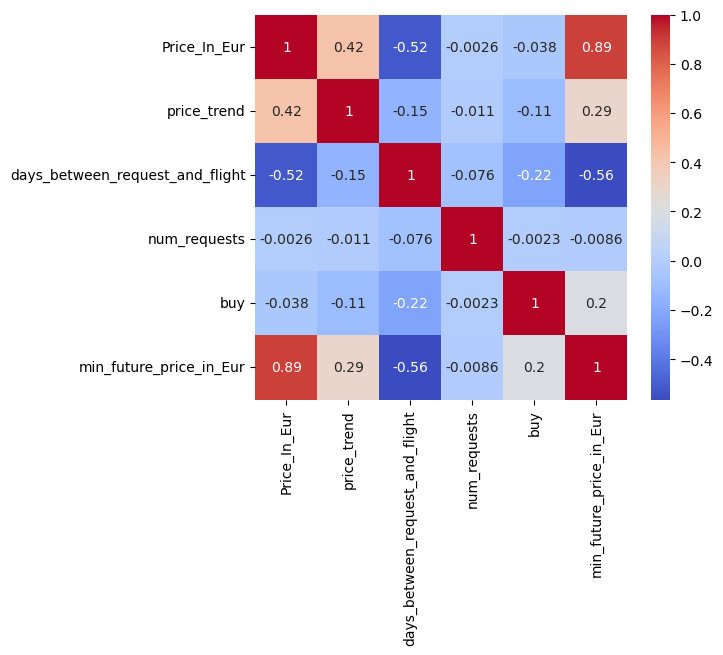

In [44]:
# Plotting correlation matrix
plt.figure(figsize = (6,5))
sns.heatmap(corr_matrix, annot = True, cmap = "coolwarm")
plt.show()

At the first sight *min_future_price_in_Eur* may be highly correlated and therefor helpful for the prediction of buy. But the buy is directly calculated out of min_future_price_in_Eur and Price_in_Eur. So it is not a good idea to use it for prediction.

Out of all the maybe relevant features we see that *days_between_request_and_flight* has the strongest correlation with buy. *price_trend* has a correlation around half as much. *num_requests* shows nearly 0 correlation. This could indicate, that days_between_request_and_flight might be helpful for the prediction.

In [45]:
# check the correlation between the features and the target variable 'min_future_price_in_Eur'
corr_matrix = df_train_copy_num.corr()
corr_matrix['min_future_price_in_Eur'].sort_values(ascending=False)

min_future_price_in_Eur            1.000000
Price_In_Eur                       0.894554
price_trend                        0.293805
buy                                0.197882
num_requests                      -0.008627
days_between_request_and_flight   -0.563969
Name: min_future_price_in_Eur, dtype: float64

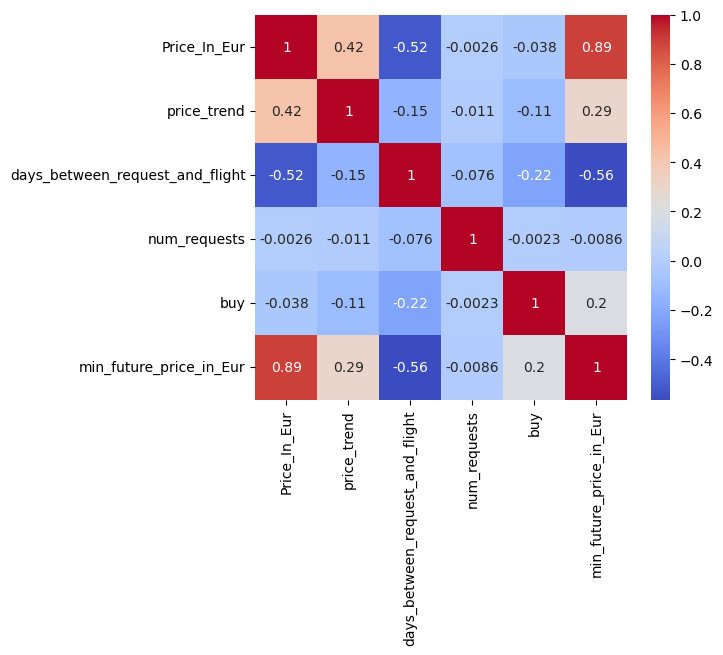

In [46]:
# Plotting correlation matrix
plt.figure(figsize = (6,5))
sns.heatmap(corr_matrix, annot = True, cmap = "coolwarm")
plt.show()

Because of the same reason as in the buy-target-variable-case, we ignore the *buy* feature.

*Price_In_Eur* is highly correlated with the minimum price which makes sense, because the minimum price and the current requestd price are not that far away from each other. 

The biggest correlation between the features and the target variable min_future_price_in_Eur exists again for the *days_between_request_and_flight*-feature. *price_trend* nearly half as big and *num_requests* is really small.

#### Categorical Features ####

Next, we investigate how the categorial features are correlated with the target variables *buy* and *min_future_price_in_Eur*. Because we alredy know, that the target variables are correlated with each other, we only look at the correlation with *buy*.

In [47]:
# get the categorical features
df_train_copy_cat = df_train_copy[['buy', 'route_abb', 'Departure_airport', 'Arrival_airport', 'Departure_hour', 'Request_Month', 'Request_Day_Of_Week', 'Request_Hour', 'Request_is_Weekend', 'Flight_Month', 'Flight_Day_Of_Week', 'Flight_is_Weekend', 'is_holiday']]

##### **Route** #####

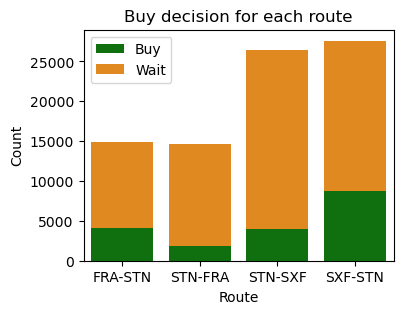

In [48]:
# Check the correlation between route_abb and the target variable 'buy'
buy_route_counts = df_train_copy_cat.groupby(['route_abb', 'buy']).size().unstack()

# Plot the data
plt.figure(figsize=(4, 3))
sns.barplot(x=buy_route_counts.index, y=buy_route_counts[1], label='Buy', color='g')
sns.barplot(x=buy_route_counts.index, y=buy_route_counts[0], bottom=buy_route_counts[1], label='Wait', color='darkorange')

plt.xlabel('Route')
plt.ylabel('Count')
plt.title('Buy decision for each route')
plt.legend()
plt.show()

There seems to be no big influence of the route on the buy decision. Maybe this can be helpful for the prediction.

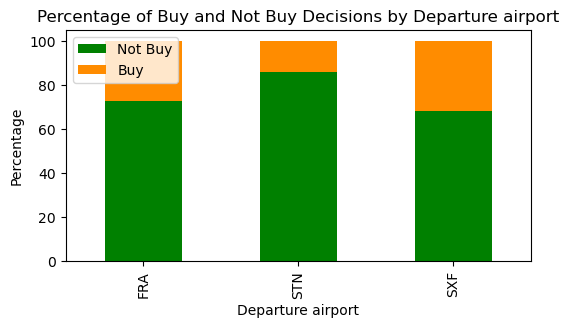

In [49]:
# Calculate the count of 'buy' and 'not buy' decisions for each Departure_airport
buy_counts = df_train_copy_cat.groupby(['Departure_airport', 'buy']).size().unstack()

# Normalize to get the proportion and multiply by 100 to get percentage
buy_percentage = (buy_counts.T / buy_counts.T.sum()).T * 100

# Create a stacked bar plot
buy_percentage.plot(kind='bar', stacked=True, figsize=(6, 3), color=['g', 'darkorange'])
plt.title('Percentage of Buy and Not Buy Decisions by Departure airport')
plt.xlabel('Departure airport')
plt.ylabel('Percentage')
plt.legend(['Not Buy', 'Buy'], loc='upper left')
plt.show()

It seems that there are a bit different amounts of buy-decisions for each Departure airport. Maybe this can be helpful for the prediction.

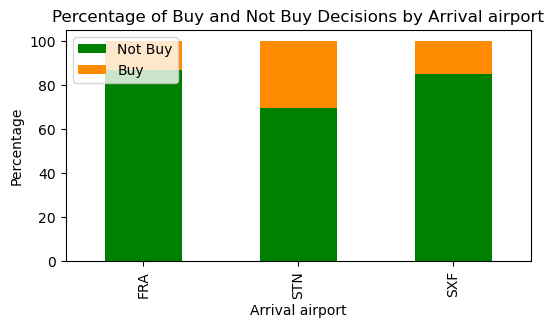

In [50]:
# Calculate the count of 'buy' and 'not buy' decisions for each Arrival_airport
buy_counts = df_train_copy_cat.groupby(['Arrival_airport', 'buy']).size().unstack()

# Normalize to get the proportion and multiply by 100 to get percentage
buy_percentage = (buy_counts.T / buy_counts.T.sum()).T * 100

# Create a stacked bar plot
buy_percentage.plot(kind='bar', stacked=True, figsize=(6, 3), color=['g', 'darkorange'])
plt.title('Percentage of Buy and Not Buy Decisions by Arrival airport')
plt.xlabel('Arrival airport')
plt.ylabel('Percentage')
plt.legend(['Not Buy', 'Buy'], loc='upper left')
plt.show()

It seems that there are a bit different amounts of buy-decisions for each Arrival airport.

##### **Departure time** #####

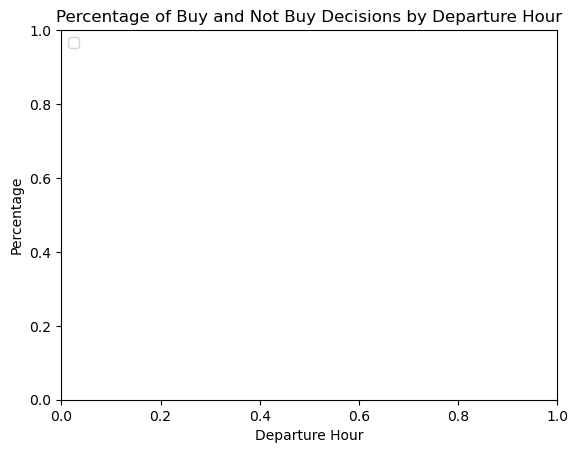

In [51]:
# Check the correlation between Departure_hour and the target variable 'buy'
buy_counts = df_train_copy_cat.groupby(['Departure_hour', 'buy']).size().unstack()

buy_percentage = (buy_counts.T / buy_counts.T.sum()).T * 100

buy_percentage.plot(kind='bar', stacked=True, figsize=(5, 4), color=['g', 'darkorange'])
plt.title('Percentage of Buy and Not Buy Decisions by Departure Hour')
plt.xlabel('Departure Hour')
plt.ylabel('Percentage')
plt.legend(['Not Buy', 'Buy'], loc='upper left')
plt.show()

It seems that the percentage of buy-reccomendation is higher for departure hours in the late morning as well as the early afternoon and late evening.

##### **Holiday** #####

True     72848
False    10776
Name: is_holiday, dtype: int64


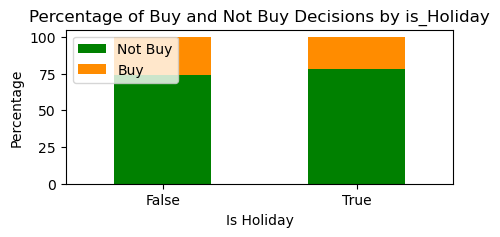

In [52]:
# Calculate the count of 'buy' and 'not buy' decisions for each holiday status
buy_counts = df_train_copy_cat.groupby(['is_holiday', 'buy']).size().unstack()

print(df_train_copy_cat['is_holiday'].value_counts())

# Normalize to get the proportion and multiply by 100 to get percentage
buy_percentage = (buy_counts.T / buy_counts.T.sum()).T * 100

# Create a stacked bar plot
buy_percentage.plot(kind='bar', stacked=True, figsize=(5, 2), color=['g', 'darkorange'])
plt.title('Percentage of Buy and Not Buy Decisions by is_Holiday')
plt.xlabel('Is Holiday')
plt.ylabel('Percentage')
plt.legend(['Not Buy', 'Buy'], loc='upper left')
plt.xticks(rotation=0)
plt.show()

The proportions of buy-reccomedation and not-buy-reccomedation for the feature is_Holiday seem to be quite the same. Therefore we can't say that this feature is a good predictor for the target variable.

##### **Request Time Data** #####

**Request_Month**

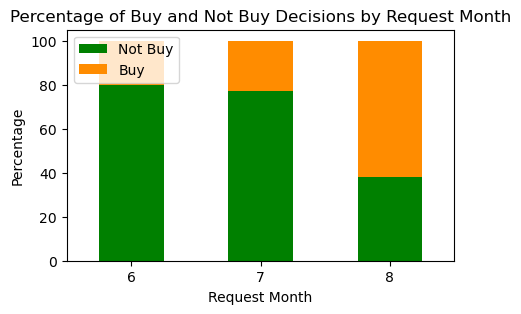

In [53]:
# Calculate the count of 'buy' and 'not buy' decisions for each Request_Month
buy_counts = df_train_copy_cat.groupby(['Request_Month', 'buy']).size().unstack()

# Normalize to get the proportion and multiply by 100 to get percentage
buy_percentage = (buy_counts.T / buy_counts.T.sum()).T * 100

# Create a stacked bar plot
buy_percentage.plot(kind='bar', stacked=True, figsize=(5, 3), color=['g', 'darkorange'])
plt.title('Percentage of Buy and Not Buy Decisions by Request Month')
plt.xlabel('Request Month')
plt.ylabel('Percentage')
plt.legend(['Not Buy', 'Buy'], loc='upper left')
plt.xticks(rotation=0)
plt.show()

There seem to be a higher percentage of buy-decisions for requests made in August. This could be a consequense of the data, which only contains data for flights departing in September latest. But this doesn't have to be the only explanation.

**Request_Day_Of_Week**

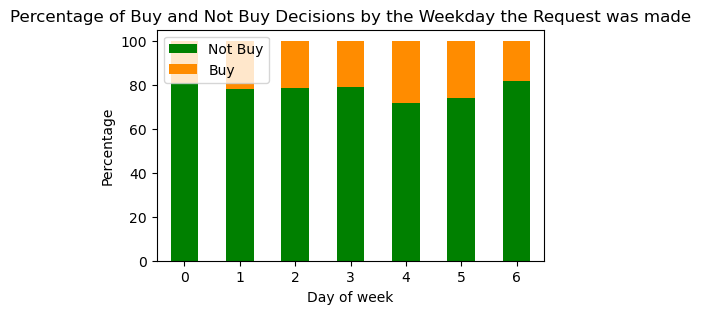

In [54]:
# Calculate the count of 'buy' and 'not buy' decisions for each Request_Day_Of_Week
buy_counts = df_train_copy_cat.groupby(['Request_Day_Of_Week', 'buy']).size().unstack()

# Normalize to get the proportion and multiply by 100 to get percentage
buy_percentage = (buy_counts.T / buy_counts.T.sum()).T * 100

# Create a stacked bar plot
buy_percentage.plot(kind='bar', stacked=True, figsize=(5, 3), color=['g', 'darkorange'])
plt.title('Percentage of Buy and Not Buy Decisions by the Weekday the Request was made')
plt.xlabel('Day of week')
plt.ylabel('Percentage')
plt.legend(['Not Buy', 'Buy'], loc='upper left')
plt.xticks(rotation=0)
plt.show()

There seems to be no big differences in the proportions and therefore no clear correlation.

**Request_Hour**

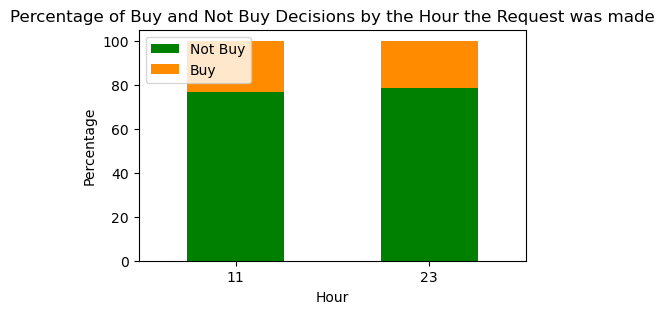

In [55]:
# Calculate the count of 'buy' and 'not buy' decisions for each Request_Hour status
buy_counts = df_train_copy_cat.groupby(['Request_Hour', 'buy']).size().unstack()

# Normalize to get the proportion and multiply by 100 to get percentage
buy_percentage = (buy_counts.T / buy_counts.T.sum()).T * 100

# Create a stacked bar plot
buy_percentage.plot(kind='bar', stacked=True, figsize=(5,3), color=['g', 'darkorange'])
plt.title('Percentage of Buy and Not Buy Decisions by the Hour the Request was made')
plt.xlabel('Hour')
plt.ylabel('Percentage')
plt.legend(['Not Buy', 'Buy'], loc='upper left')
plt.xticks(rotation=0)
plt.show()

There seems to be no big differences in the proportions and therefore no clear correlation.

**Request_is_Weekend**

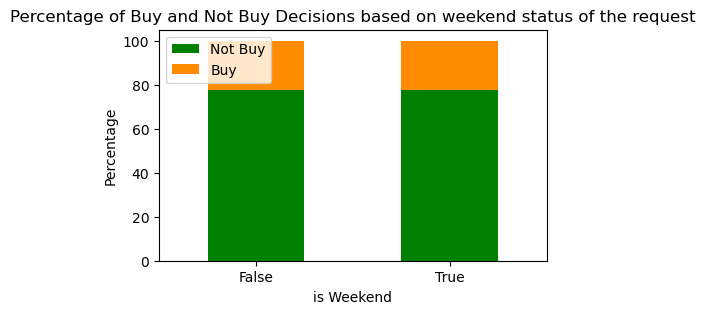

In [56]:
# Calculate the count of 'buy' and 'not buy' decisions for each Request_is_Weekend status
buy_counts = df_train_copy_cat.groupby(['Request_is_Weekend', 'buy']).size().unstack()

# Normalize to get the proportion and multiply by 100 to get percentage
buy_percentage = (buy_counts.T / buy_counts.T.sum()).T * 100

# Create a stacked bar plot
buy_percentage.plot(kind='bar', stacked=True, figsize=(5,3), color=['g', 'darkorange'])
plt.title('Percentage of Buy and Not Buy Decisions based on weekend status of the request')
plt.xlabel('is Weekend')
plt.ylabel('Percentage')
plt.legend(['Not Buy', 'Buy'], loc='upper left')
plt.xticks(rotation=0)
plt.show()

There seems to be no big differences in the proportions and therefore no clear correlation.

##### **Flight Time Data** #####

**Flight_Month**

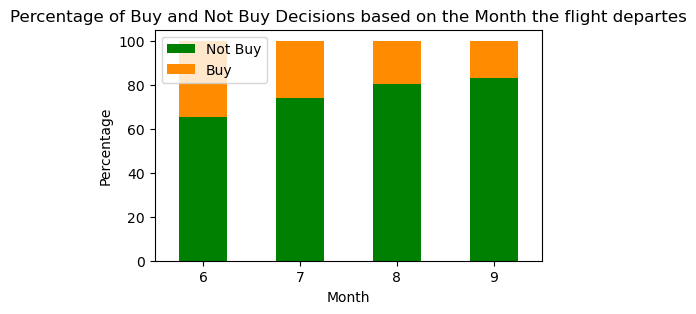

In [57]:
# Calculate the count of 'buy' and 'not buy' decisions for each Flight_Month
buy_counts = df_train_copy_cat.groupby(['Flight_Month', 'buy']).size().unstack()

# Normalize to get the proportion and multiply by 100 to get percentage
buy_percentage = (buy_counts.T / buy_counts.T.sum()).T * 100

# Create a stacked bar plot
buy_percentage.plot(kind='bar', stacked=True, figsize=(5,3), color=['g', 'darkorange'])
plt.title('Percentage of Buy and Not Buy Decisions based on the Month the flight departes')
plt.xlabel('Month')
plt.ylabel('Percentage')
plt.legend(['Not Buy', 'Buy'], loc='upper left')
plt.xticks(rotation=0)
plt.show()

There seems to be more buy recommendations for flights that departe earlier in the year. This could be due to the fact, that we only have a limited range of months contained in the dataset. Meaning, if we have a Flight departing at June, but we only have data for requests since June, we can't wait to buy the ticket, because the flight starts only a short time after the request. But this doesn't have to be the only reason for this decrease in buy-decisions over the year.

**Flight_Day_Of_Week**

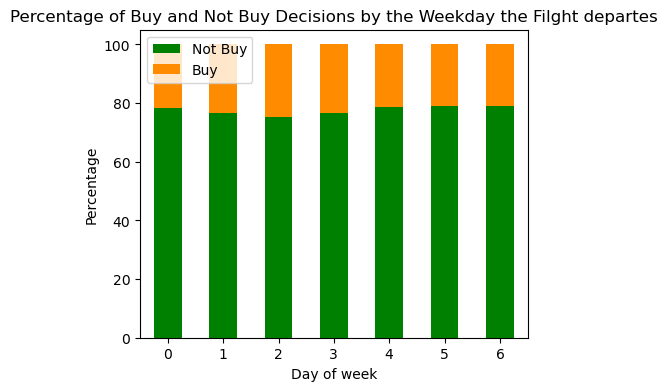

In [58]:
# Calculate the count of 'buy' and 'not buy' decisions for each Flight_Day_Of_Week
buy_counts = df_train_copy_cat.groupby(['Flight_Day_Of_Week', 'buy']).size().unstack()

# Normalize to get the proportion and multiply by 100 to get percentage
buy_percentage = (buy_counts.T / buy_counts.T.sum()).T * 100

# Create a stacked bar plot
buy_percentage.plot(kind='bar', stacked=True, figsize=(5, 4), color=['g', 'darkorange'])
plt.title('Percentage of Buy and Not Buy Decisions by the Weekday the Filght departes')
plt.xlabel('Day of week')
plt.ylabel('Percentage')
plt.legend(['Not Buy', 'Buy'], loc='upper left')
plt.xticks(rotation=0)
plt.show()

There seems to be no big differences in the proportions and therefore no clear correlation.

**Flight_is_Weekend**

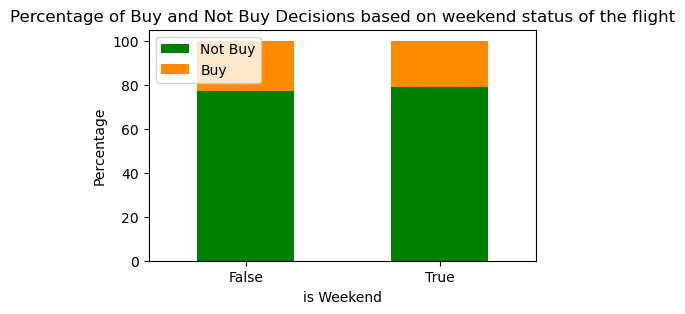

In [59]:
# Calculate the count of 'buy' and 'not buy' decisions for each Request_is_Weekend status
buy_counts = df_train_copy_cat.groupby(['Flight_is_Weekend', 'buy']).size().unstack()

# Normalize to get the proportion and multiply by 100 to get percentage
buy_percentage = (buy_counts.T / buy_counts.T.sum()).T * 100

# Create a stacked bar plot
buy_percentage.plot(kind='bar', stacked=True, figsize=(5,3), color=['g', 'darkorange'])
plt.title('Percentage of Buy and Not Buy Decisions based on weekend status of the flight')
plt.xlabel('is Weekend')
plt.ylabel('Percentage')
plt.legend(['Not Buy', 'Buy'], loc='upper left')
plt.xticks(rotation=0)
plt.show()

There seems to be no big differences in the proportions and therefore no clear correlation.

### Select most important features ###

Now, we have manually inspected the numerical and categoriel features to find features that might be important for the model.

Additionally, we will now use a method to find the most important features for the model based on the results of SelectKBest. This method is a statistical test to evaluate the relationship between each feature and the target variable. The function then returns the K best features (K is freely selecteable) based on the results of the statistical test.

#### SelectKBest for Classification (target variable: buy) ####

In [60]:
# copy the data
df_train_copy_kbest_cl = df_train_copy.copy()

# separate the features and the target variable 'min_future_price_in_Eur'
X = df_train_copy_kbest_cl.drop(['buy', 'Request_Date', 'Flight_Date', 'flight_unique_id'], axis=1)
Y = df_train_copy_kbest_cl['buy']

# convert the categorical columns to numerical
X = pd.get_dummies(X)

# apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=mutual_info_classif , k=20) 
fit = bestfeatures.fit(X, Y)

# create a dataframe with the scores
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

# concat the two dataframes for better visualization
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs', 'Score']

# print the 20 best features
featureScores.nlargest(20, 'Score')


,Specs,Score
0,index,0.277162
3,min_future_price_in_Eur,0.085147
2,Price_In_Eur,0.080563
14,price_trend,0.061114
11,days_between_request_and_flight,0.034550
20,Departure_airport_STN,0.023190
23,Arrival_airport_STN,0.022060
18,route_abb_SXF-STN,0.015901
4,Request_Month,0.015057
1,Departure_hour,0.014791


The results align with our previously findings, so we select the following features for our model training:

- *Price_In_Eur*
- *price_trend*
- *days_between_request_and_flight*
- *Departure_airport*
- *Arrival_airport*
- *Departure_hour*
- *Request_Month*
- *Flight_Month*
- *num_requests*
- *is_holiday*

## Data Preprocessing ##

In the data preprocessing phase, we'll conduct the necessary preprocessing steps to convert the raw data (train.csv) into a suitable format for machine learning models. This means, we copy the data again and clean, select features and engineer features based on the results of the Data Exploration and Feature Engineering step. For example, we'll convert the categorical features or add the feature 'days_between_request_and_flight'.

In [61]:
# copy the data again from the original dataframe
df_train_copy = df_train.copy()

-  No removing of outliers, because there are no outliers in the data.
-  No filling of missing values, because there are no missing values in the data.

- Price_In_Eur
- price_trend
- days_between_request_and_flight
- Departure_airport
- Arrival_airport
- Departure_hour
- Request_Month
- Flight_Month
- num_requests
- is_holiday

-  Remove *index* because it is not needed anymore.

In [62]:
# drop the columns that are not needed
df_train_copy.drop(['index'], axis=1, inplace=True)

-  Create *Departure_airport* and *Arrival_airport* from *route_abb* and encode them with OneHotEncoder.

In [63]:
# Extract departure and arrival airport from route_abb
df_train_copy['Departure_airport'] = df_train_copy['route_abb'].str.split('-').str[0]
df_train_copy['Arrival_airport'] = df_train_copy['route_abb'].str.split('-').str[1]

# One hot encoding for departure and arrival airport
df_train_copy = pd.get_dummies(df_train_copy, columns=['Departure_airport', 'Arrival_airport'])

# drop route_abb column
df_train_copy.drop('route_abb', axis=1, inplace=True)


-  Convert *Request_date* and *Flight_date* to datetime. Remove timezone information from *Request_date*.

In [64]:
# convert Request date to datetime
df_train_copy['Request_Date'] = pd.to_datetime(df_train_copy['Request_Date'])

# remove the timezone from the request date
df_train_copy['Request_Date'] = df_train_copy['Request_Date'].dt.tz_convert(None)

# convert Flight date to datetime
df_train_copy['Flight_Date'] = pd.to_datetime(df_train_copy['Flight_Date'])

-  Create *days_between_request_and_flight_date* from *Request_date* and *Flight_date*.

In [65]:
# create column days_between_request_and_flight
df_train_copy['days_between_request_and_flight'] = (df_train_copy['Flight_Date'] - df_train_copy['Request_Date']).dt.days

-  Create *Request_Month* from *Request_date*. Then remove *Request_date*.

In [66]:
# create Request_Month column
df_train_copy['Request_Month'] = df_train_copy['Request_Date'].dt.month

-  Create *Flight_Month* from *Flight_date*.

In [67]:
# create column Flight_month
df_train_copy['Flight_Month'] = df_train_copy['Flight_Date'].dt.month

- Create *is_holiday* based on *Flight_Date*.

In [68]:
# create column 'is_holiday'
df_train_copy['is_holiday'] = df_train_copy['Flight_Date'].apply(is_holiday_uk_ger)

# drop column Flight_Date
df_train_copy.drop('Flight_Date', axis=1, inplace=True)

- Create *price_trend* throug the price_trend-Function we defined in the Data Exploration and Feature Engineering phase.

In [69]:
# create column 'price_trend'
price_trend()

- Create *num_requests* through the rolling_num_requests function we created earlier.

In [70]:
# create column 'num_requests'
rolling_num_requests()

In [71]:
# check the new df_train_price dataframe
df_train_copy.head()

,Request_Date,Departure_hour,flight_unique_id,Price_In_Eur,min_future_price_in_Eur,buy,Departure_airport_FRA,Departure_airport_STN,Departure_airport_SXF,Arrival_airport_FRA,Arrival_airport_STN,Arrival_airport_SXF,days_between_request_and_flight,Request_Month,Flight_Month,is_holiday,price_trend,num_requests
0,2019-06-03 11:00:00,19,2019-06-05 FR 146,208.07,259.07,1,0,0,1,0,1,0,1,6,6,0,0.00,1.0
1,2019-06-03 23:00:00,19,2019-06-05 FR 146,259.07,259.07,1,0,0,1,0,1,0,1,6,6,0,25.50,2.0
2,2019-06-04 11:00:00,19,2019-06-05 FR 146,259.07,259.07,1,0,0,1,0,1,0,0,6,6,0,8.50,3.0
3,2019-06-04 23:00:00,19,2019-06-05 FR 146,259.07,259.07,1,0,0,1,0,1,0,0,6,6,0,4.25,4.0
4,2019-06-03 11:00:00,21,2019-06-05 FR 147,143.86,251.72,1,0,1,0,0,0,1,1,6,6,0,0.00,1.0


## Model Selection ##

In the model selection phase, we try out different models and optimize their hyperparameters to choose the most suitable machine learning algorithm for our specific problem, based on the outcomes of the data preparation and feature selection process. 

We decided to directly predict buy, meaning that we have an classification problem and we will train 3 different classifiers.

### Preparation for model training ###

#### Define the target variable and the features ####

In [72]:
# Define the features and the target
X = df_train_copy[['Request_Date', 'Departure_hour', 'flight_unique_id', 'Price_In_Eur', 'Departure_airport_FRA',
     'Departure_airport_STN', 'Departure_airport_SXF', 'Arrival_airport_FRA', 'Arrival_airport_STN', 'Arrival_airport_SXF', 'days_between_request_and_flight', 'Request_Month', 'Flight_Month', 'is_holiday', 'price_trend', 'num_requests']]
y = df_train_copy['buy']

#### Scaling ####

Some machine learning algorithms are sensitive to the scale of the input data. For example, algorithms that use a distance measure, such as k-nearest neighbors (KNN) or support vector machines (SVM), can be affected if the features are not on the same scale. Therefore, it is common practice to make sure, that the nominal features have the same scale. We standardize the data, so that the features are centered around 0 (mean = 0) with a standard deviation of 1. After this transformation, the features will have the same scale and we can use it for example for an KNN.

In [73]:
# define scaler
scaler = StandardScaler()

# List of numerical columns
numerical_cols = ['Price_In_Eur', 'days_between_request_and_flight', 'num_requests', 'price_trend']
numerical_cols = ['Price_In_Eur', 'days_between_request_and_flight', 'num_requests', 'price_trend']

# Fit the StandardScaler and transform the numerical columns
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

#### Split the data ####

In [74]:
# Split the data into train and test data
X_train_full, X_test_full, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# remove the flight_unique_id from the train and test data
X_train = X_train_full.drop(['flight_unique_id', 'Request_Date'], axis=1)
X_test = X_test_full.drop(['flight_unique_id', 'Request_Date'], axis=1)

Our X_train_full contains all features, meaning also the features that are not useful for our model, but we need for model evaluation purposes. Those are *Request_Date* and *flight_unique_id*. We drop those two features for the training and testing data X_train and X_test. Those data sets are used to train and test the model.

#### Model Quality Evaluation Function by Prof. Spott ####

To calculate whether a model is good and makes good buy-suggestions, we use a custom metric which was provided by Prof. Dr. Martin Spott. The concept of this quality measurement is at follows:

It could be that 9 times out of 10 we correctly predict that it is best to buy the ticket now. But then the one time we wrongly give a buy recommendation, the ticket price is currently very high and we make a big loss. In contrast, it could be that we have only saved minimally on the 9 correct predictions. This encompasses the model quality evaluation function.

We will later use it to calculate the quality of our models.

In [75]:
# The model quality evaluation function expects a Pandas dataframe with at least the following columns:
# Request_Date          int64
# flight_unique_id     object
# Price               float64
# buy                    bool

def model_quality_evaluation(df):
    # Make a copy of the provided dataframe as to not modify the original.
    df = df.copy()

    # Convert 'Price' to whole cents and store as integers to avoid floating point errors.
    df['Price_In_Eur'] = df['Price_In_Eur'] * 100
    df['Price_In_Eur'] = df['Price_In_Eur'].astype(int)

    # Initialize a variable that stores the sum of all our balances.
    sum_balances = 0

    # Get a list of all 'flight_unique_id'.
    flight_unique_ids = df['flight_unique_id'].unique()

    # Iterate over all 'flight_unique_id'.
    for flight_unique_id in flight_unique_ids:
        # Get a subset of the data for the specified 'flight_unique_id'.
        df_subset = df[df['flight_unique_id'] == flight_unique_id]

        # Get all request dates except for the latest request date before departure.
        # At the latest request date before departure we need to buy a ticket anyway,
        # so we don't care about this specific request date.
        request_dates = df_subset[df_subset['Request_Date'] != df_subset['Request_Date'].max()]

        # Make sure request dates are sorted in descending order.
        request_dates.sort_values(by='Request_Date', ascending=False, inplace=True)

        # Get the ticket price from the latest request date before departure,
        # because we certainly have to buy a ticket at this date.
        last_buying_price = df_subset[df_subset['Request_Date'] == df_subset['Request_Date'].max()]['Price_In_Eur'].values[0]

        # Iterate over the remaining request dates
        for _, row in request_dates.iterrows():
            # and check wether the model wants to buy a ticket at the specific request date.
            if(row['buy'] == True):
                # If the model decides to buy a ticket the last buying price is set to the
                # price point of this request date and the balance doesn't change.
                last_buying_price = row['Price_In_Eur']
            else:
                # If the models decides to not buy a ticket the balance equals the
                # the current ticket price minus the last buying price.
                current_price = row['Price_In_Eur']
                balance = current_price - last_buying_price

                # The balance is added to the sum of all balances.
                sum_balances = sum_balances + balance

    # Return the sum of all our previously calculated balances.
    return sum_balances / 100

#### Sensitivity Analysis ####

To check which score might be useful to optimise the model with respect to the custom model quality, we will perform a sensitivity analysis. We want to examine how much the model quality changes with changes in false negative (FN) and false positive (FP) values.

In this analysis, we set a baseline that randomly generates buy data and adds it to our data set. This baseline serves as a reference for the next steps.
In these steps, we will use cross-validation to test how an increase in false negative and false positive values affects the model quality. Meaning if we increase FN, does the model quality then decreases more than by increasing the FP values.

In [76]:
## Create baseline dataframe

# create random predictions
predictions = np.random.randint(0, 2, size=len(df_train_copy))

# baseline score
baseline_df = df_train_copy.copy()
baseline_df['buy'] = predictions
baseline_score = model_quality_evaluation(baseline_df)

tn, fp, fn, tp = confusion_matrix(df_train_copy['buy'], baseline_df['buy']).ravel()
print('TN: ', tn, 'FP: ', fp, 'FN: ', fn, 'TP: ', tp)

print(baseline_score)

TN:  32641 FP:  32265 FN:  9335 TP:  9383
-76032.78


In [77]:
def calculate_sensitivity():    
    n_fold = 10

    # store custom scores for each fold
    custom_scores_fn_up = []
    custom_scores_fp_up = []

    # iterate over foldss
    for i in range(n_fold):
        df_copy = baseline_df.copy()
        
        # Scenario 1: Increasing FN
        false_negatives = df_copy[(df_copy['buy'] == 0) & (df_train_copy['buy'] == 1)]
        n_to_change = int((len(false_negatives)/3))

        if not false_negatives.empty:
            samples_tp = false_negatives.sample(n=n_to_change)
            df_copy.loc[samples_tp.index, 'buy'] = 1
        custom_score_fn_up = model_quality_evaluation(df_copy)
        custom_scores_fn_up.append(custom_score_fn_up)
        
        # Scenario 2: Increasing FP
        false_positives = df_copy[(df_copy['buy'] == 1) & (df_train_copy['buy'] == 0)]
        n_to_change = int(len(false_positives)/3)

        if not false_positives.empty:
            samples_fp = false_positives.sample(n=n_to_change)
            df_copy.loc[samples_fp.index, 'buy'] = 0
        custom_score_fp_up = model_quality_evaluation(df_copy)
        custom_scores_fp_up.append(custom_score_fp_up)

    # average scores across all folds
    avg_custom_score_fn_up = np.mean(custom_scores_fn_up)
    avg_custom_score_fp_up = np.mean(custom_scores_fp_up)

    # Create a figure and a set of subplots
    fig, ax = plt.subplots()

    # Create a line chart with filled area between lines
    iterations = np.arange(1, n_fold + 1)
    ax.fill_between(iterations, 
                    np.minimum(custom_scores_fn_up, custom_scores_fp_up), 
                    np.maximum(custom_scores_fn_up, custom_scores_fp_up), 
                    color="lightgrey", alpha=0.5)
    ax.plot(iterations, custom_scores_fn_up, 'o-', color="r", label="FN up")
    ax.plot(iterations, custom_scores_fp_up, 'o-', color="g", label="FP up")

    ax.set_xlabel("Iteration")
    ax.set_ylabel("Score")
    ax.legend(loc="best")
    ax.grid()

    plt.show()
    
    print('Average custom score with increased FN: ', avg_custom_score_fn_up)
    print('Average custom score with increased FP: ', avg_custom_score_fp_up)

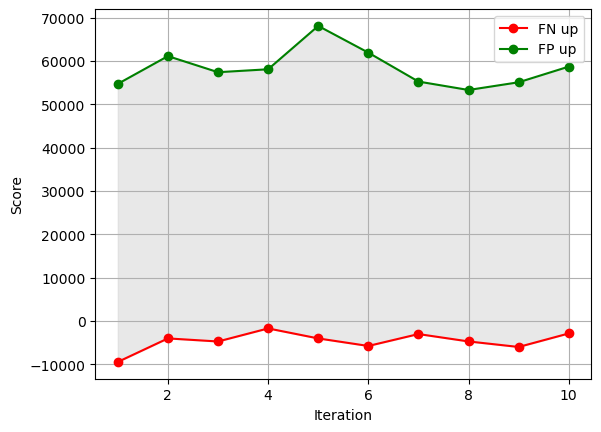

Average custom score with increased FN:  -4629.466
Average custom score with increased FP:  58357.287


In [78]:
calculate_sensitivity()

In the results of the cross-validation we can see that the model quality based on the custom model evaluation is more sensitive to false positive values than to false negative values. We can see this in the diagram that the FN-score is at average 63184.893 better than the score of the baseline we previously defined.
This means, if we falsely predict that one should by a ticket now, but the price will actually go down, it is worse than if we falsely predict that one should wait, but the price will actually go up. 


To conclude, we have determined that false positives  are more costly than false negatives. Consequently, the F1 score is an appropriate metric, ensuring that we strike a balance between precision and recall while minimizing the cost of false positives. This approach aligns with our objective of providing accurate buy/wait recommendations to potential flight purchasers, with an emphasis on avoiding premature buying decisions that could lead to unnecessary expenses.

#### Define helper functions for quality evaluation ####

In the model training, we want to investigate different metrics, not only the custom model quality evaluation function we previously defined. We also want to look at the model's performance in terms of accuracy, precision, recall, roc auc and F1-score. Additionally, we want to look at the confusion matrix to see how many false positives and false negatives we have. Then we want to look at the learning curve, meaning how the model's performance changes with the number of examples for training and testing. Finally, we want to look at the roc-curve to see how the true positive rate and false positive rate change with the threshold.

For all these metrics, we defined helper functions we can call in the model training easily.

In [79]:
# Create a function to calculate the metrics
def calculate_metrics(y_test, y_pred):
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('Precision: ', precision_score(y_test, y_pred))
    print('Recall: ', recall_score(y_test, y_pred))
    print('F1: ', f1_score(y_test, y_pred))
    print('ROC AUC: ', roc_auc_score(y_test, y_pred))

# Create a function to plot the confusion matrix
def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, cmap='coolwarm', fmt='.2f')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Create a function to plot the Learning Curve
def plot_learning_curve(estimator, X, y, cv=5):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(4, 3))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

# Create a function to plot the ROC Curve
def plot_roc_curve(estimator, X, y, cv=5):
    # Compute probabilities
    y_pred_prob = estimator.predict_proba(X_test)[:,1]
    
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(4, 3))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

#### Custom Score Function ####

Because the X_train and X_test data do not contain the features *flight_unique_id* and *Request_Date* for the custom model quality evaluation we need to add these columns back to the dataframe, we use to calculate the custom model quality evaluation function. Therefore we create a new dataframe containing the transfered data (e.g. X_test), which does not contain those features and adds the two columns *flight_unique_id* and *Request_Date* by using the transferred matching full dataset (e.g. X_test_full), which contains all columns. Then we also add the *buy*-predictions to the dataframe because this is also needed for the custom model quality evaluation function.

The custom_metric function prepares the data for the custom model quality evaluation function and calls the function. The custom model quality evaluation function calculates the custom model quality evaluation metric and returns the result.

In [80]:
def custom_metric(y_pred, X, X_full):

    test_df = X.copy()
    test_df['Request_Date'] = X_full.loc[X.index, 'Request_Date']
    test_df['flight_unique_id'] = X_full.loc[X.index, 'flight_unique_id']
    test_df['Price_In_Eur'] = X_full.loc[X.index, 'Price_In_Eur']
    test_df['buy'] = y_pred

    # Convert the data types to match the custom metric function requirements
    test_df['Request_Date'] = test_df['Request_Date'].dt.dayofyear
    test_df['buy'] = test_df['buy'].astype(bool)

    # Call the original evaluation function
    return model_quality_evaluation(test_df)

Now we are ready to train some models. We will use the following algorithms:
- Random Forest Classifier
- XGBoost Classifier (TODO: ist das ein gradientboostclassifier)

#### What if we always predict not to buy? ####

As a reference point, we calculate the score for the custom evaluation, if we would always predict to wait. So the model we train should defenitely be better than this.

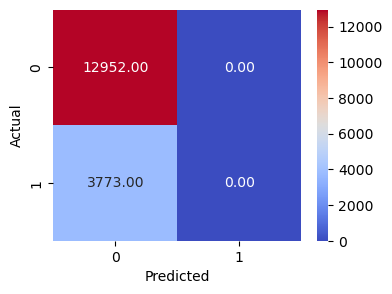

In [81]:
predictions_not_buy = np.zeros(len(y_test))
plot_confusion_matrix(y_test, predictions_not_buy)

In [82]:
print('Custom model quality evaluation reference: ', custom_metric(predictions_not_buy, X_test, X_test_full))

Custom model quality evaluation reference:  -14318.32


### Model Training ###

Now as we have defined helper functions for model evaluation and made sure to understand, which score might be important for our problem, we can start with the actual model training. We will look at different models to compare their performance in the next step. The models are:
* Decision Tree Classifier
* Random Forest Classifier
* XGBoost Classifier
* Gradient Boosting Classifier

#### Decision Tree Classifier ####

First, we train an classic Decision Tree Classifier.

In [83]:
# define the model
dtc = DecisionTreeClassifier(random_state=42)

# train the model
dtc.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

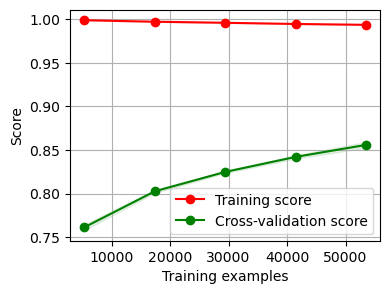

In [84]:
# look at the learning curve of the decision tree classifier
plot_learning_curve(dtc, X_train, y_train)

The training score is extremely high compared to the cross-validation score, which is an indicator, that the model is overfitting the training data. We try to solve this in the hyperparameter tuning.

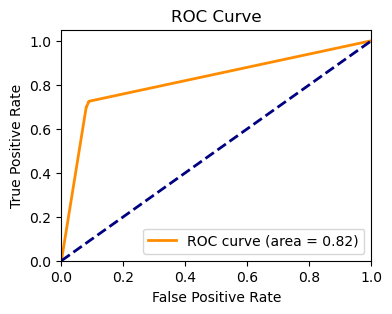

In [85]:
# look at the roc curve
plot_roc_curve(dtc, X_test, y_test)

There is a knik in the curve at around 0.1 FPR after which the curve becomes steeper. The roc curve should be more towards the top left corner. But it is better than guessing. Maybe we can improve this curve by hyperparameter tuning.

Accuracy:  0.8694170403587443
Precision:  0.7140932363244409
Recall:  0.7023588656241717
F1:  0.7081774452164616
ROC AUC:  0.8102205075495781
Custom model quality evaluation:  -880.19


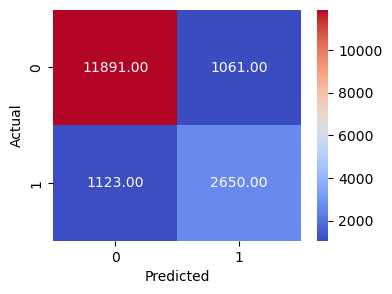

In [86]:
# Make predictions on the test set
predictions = dtc.predict(X_test)
calculate_metrics(y_test, predictions)
print('Custom model quality evaluation: ', custom_metric(predictions, X_test, X_test_full))
plot_confusion_matrix(y_test, predictions)

We can see based on the the metrics, that the performance is quiet okay based on the metrics. Let's try to improve the performance by using different hyperparameters.

##### Optimize the hyperparameters #####

At first, we performe a **GridSearchCV** to find the best parameters for our model. We use the following parameters grid.

In [87]:
param_grid = {
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_leaf': [1, 2, 4, 8, 16],
    'min_samples_split': [2, 4, 8, 16, 32],
    'criterion': ['gini', 'entropy']
}

In [88]:
# create new classifier to prevent overfitting
dt = DecisionTreeClassifier(random_state=42)

# perform the grid search
grid_search = GridSearchCV(
    dt,
    param_grid,
    scoring='f1',
    cv=5
    )
grid_search.fit(X_train, y_train)


print("Best params: ", grid_search.best_params_)

# save best params
best_params = grid_search.best_params_

Best params:  {'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2}


Now, we retrain the model based on the results for the best hyperparameters found above.

In [89]:
dtc = DecisionTreeClassifier(random_state=42, **best_params)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=30, random_state=42)

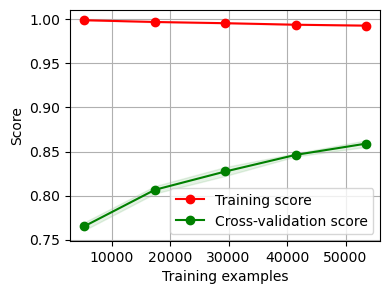

In [90]:
plot_learning_curve(dtc, X_train, y_train)

Again, the training score is extremely high compared to the cross-validation score.

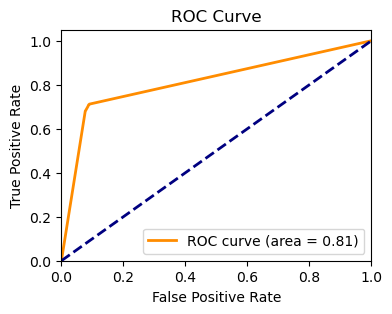

In [91]:
plot_roc_curve(dtc, X_test, y_test)

The roc-curve also didn't improve due to the hyperparameter tuning.

Accuracy:  0.8676233183856502
Precision:  0.7157486853030722
Recall:  0.6853962364166446
F1:  0.7002437043054427
ROC AUC:  0.8030517315498912
Custom model quality evaluation:  -1045.81


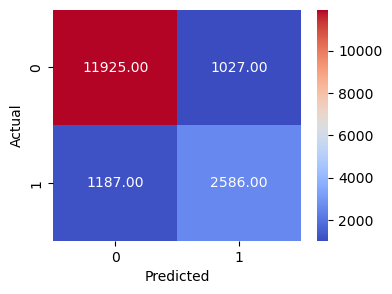

In [92]:
# Make predictions on the test set
predictions = dtc.predict(X_test)
calculate_metrics(y_test, predictions)
print('Custom model quality evaluation: ', custom_metric(predictions, X_test, X_test_full))
plot_confusion_matrix(y_test, predictions)

We can see that the number of TPs has decreased a little, but the number of FP has also increased. Also the overall performance for each metric has been better without the optimized parameters. 

Let's move on to the next Classifier and try to find out how this performs.

#### Random Forest Classifier ####

In [93]:
# Train a Random Forest Classifier
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

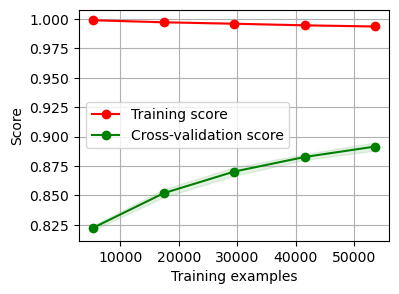

In [94]:
plot_learning_curve(rfc, X_train, y_train)

Like in the decision tree classifier, the learning curve seems to show that we overfit the data.

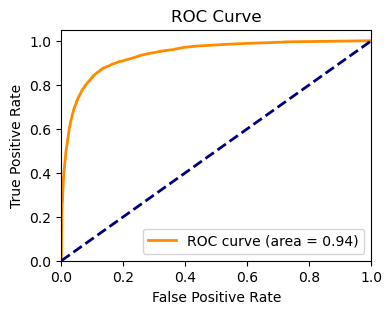

In [95]:
plot_roc_curve(rfc, X_test, y_test)

The roc-curve looks quite good for the model.

Accuracy:  0.8992526158445441
Precision:  0.8299620733249052
Recall:  0.6959978796713491
F1:  0.7570996107827592
ROC AUC:  0.8272299466299919
Custom model quality evaluation:  -1923.78


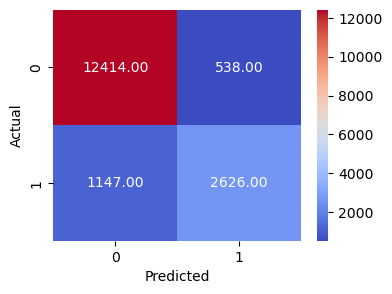

In [96]:
# Make predictions on the test set
predictions = rfc.predict(X_test)
calculate_metrics(y_test, predictions)
print('Custom model quality evaluation: ', custom_metric(predictions, X_test, X_test_full))
plot_confusion_matrix(y_test, predictions)

The results show, that all measurements exept the recall and therefore the custom model quality evaluation are better than in the decision tree classifier. So this model seems to could a good fit for our data, we can begin to optimize the hyperparameters. Hopefully we can improve the performance of our model further.

##### Optimize Hyperparameters #####

In [97]:
param_grid = {
    'n_estimators': [50, 200, 400, 800],
    'max_depth': [10, 20, 30],
    'min_samples_split': [5, 20, 35],
    'min_samples_leaf': [5, 20, 35],
    'max_leaf_nodes': [5, 15, 25]
}

This time, we try out a approache to optimize the hyperparameters. We now use the **RandomizedSearchCV**. This method is faster, but does not try out all possible combinations of hyperparameters. Instead, it tries out a given number of random combinations. We use this because the computation costs for the GridSearchCV.

In [98]:
## Randomized Search CV

rfc = RandomForestClassifier(random_state=42)

# perform RandomizedSearchCV
randomized_search = RandomizedSearchCV(
    rfc, 
    param_distributions=param_grid,
    cv=5, 
    scoring='f1',
    random_state=42)

randomized_search.fit(X_train, y_train)

print("Best params: ", randomized_search.best_params_)
print("Best score: ", randomized_search.best_score_)

best_params = randomized_search.best_params_

Best params:  {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_leaf_nodes': 25, 'max_depth': 20}
Best score:  0.2716274953296856


Accuracy:  0.8032286995515695
Precision:  0.8442857142857143
Recall:  0.15663927908825867
F1:  0.2642521797451375
ROC AUC:  0.5741117951957662
Custom model quality evaluation:  -11983.29


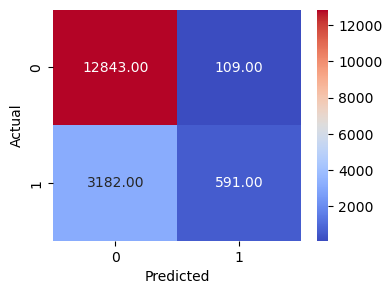

In [99]:
# retrain the model with the optimized hyperparameters by RandomizedSearchCV
rfc_rs_cv = RandomForestClassifier(**best_params, random_state=42)
rfc_rs_cv.fit(X_train, y_train)

# Make predictions on the test set
predictions = rfc_rs_cv.predict(X_test)
calculate_metrics(y_test, predictions)
print('Custom model quality evaluation: ', custom_metric(predictions, X_test, X_test_full))
plot_confusion_matrix(y_test, predictions)

The number of FP has decreased a lot, but the number of FN has increased a lot. This is not good. The f1 score also now is really high. The model is overfitting and performed better before the hyperparameter tuning.

#### XGBoostClassifier ####

Next, we train another model, XGBoost, which s an implementation of the gradient tree boosting algorithm.

In [101]:
# define model
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=42
)

# train model
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

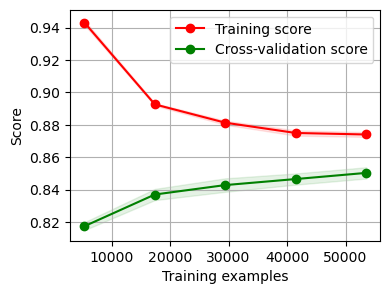

In [102]:
plot_learning_curve(xgb_model, X_train, y_train)

The Training score again is higher than the cross-validation score. But it is not as high as the previous models and is decreasing more. Therefore it could be more promising than the previous models.

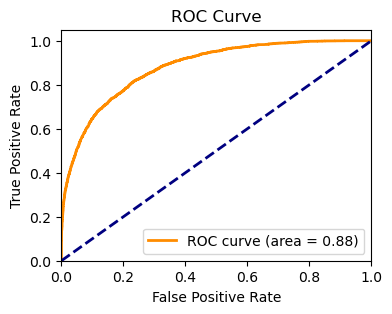

In [103]:
plot_roc_curve(xgb_model, X_test, y_test)

The roc-curve looks good. It is a clear curve, which is defenitely better than guessing. But maybe we can improve it.

Accuracy:  0.8472346786248132
Precision:  0.7748194945848376
Recall:  0.4550755367081898
F1:  0.5733845383202539
ROC AUC:  0.7082743341354414
Custom model quality evaluation:  -5952.69


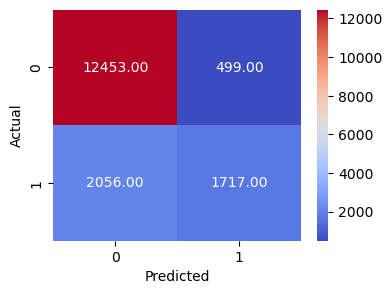

In [104]:
# Make predictions on the test set
predictions = xgb_model.predict(X_test)
calculate_metrics(y_test, predictions)
print('Custom model quality evaluation: ', custom_metric(predictions, X_test, X_test_full))
plot_confusion_matrix(y_test, predictions)

The custom model quality evaluation score is really low compared to the other models. We have a relatively high Error rate. But the XGBoost model is theoretically a really good model, so we try to optimize the hyperparameters for this model as well.

##### Optimize Hyperparameters #####

In [105]:
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [5, 10, 15, 20],
    'learning_rate': [0.01, 0.1, 0.2, 0.3]
}

In [106]:
# create new classifier
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=42
)

# perform GridSearchCV
grid_search_cv = GridSearchCV(
    estimator = xgb_model,
    param_grid = param_grid,
    cv = 5,
    scoring = 'f1'
)

grid_search_cv.fit(X_train, y_train)

print("Best params: ", grid_search_cv.best_params_)
print("Best score: ", grid_search_cv.best_score_)

best_params = grid_search_cv.best_params_

Best params:  {'learning_rate': 0.3, 'max_depth': 20, 'n_estimators': 400}
Best score:  0.7435560999510374


Let's retrain the model and make predictions.

In [107]:
# Retrain model with optimized params
xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='binary:logistic',
    random_state=42
)

xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

Accuracy:  0.9000896860986547
Precision:  0.8180992736077481
Recall:  0.7164060429366552
F1:  0.7638830012717254
ROC AUC:  0.8350019714374445
Custom model quality evaluation:  -1450.29


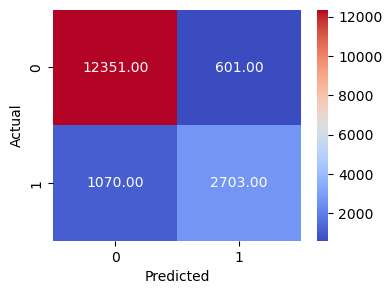

In [108]:
# Make predictions on the test set
predictions = xgb_model.predict(X_test)
calculate_metrics(y_test, predictions)
print('Custom model quality evaluation: ', custom_metric(predictions, X_test, X_test_full))
plot_confusion_matrix(y_test, predictions)

The number of FP has increased a little, but the number of FN has decreased a lot. We can see that the model has improved, also based on the metrics.

#### Gradient Boosting Classifier ####

Last but not least, we try out a Gradient Boosting Classifier.

In [109]:
# define the model
gbc = GradientBoostingClassifier(random_state=42)

# fit the model
gbc.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

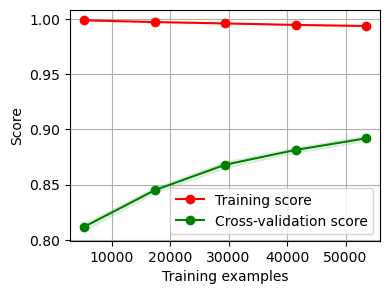

In [110]:
plot_learning_curve(xgb_model, X_train, y_train)

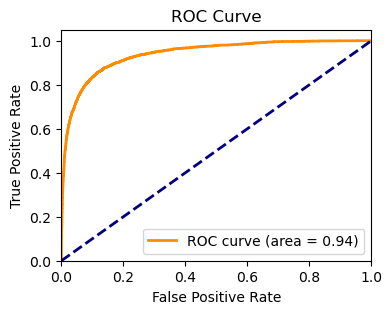

In [111]:
plot_roc_curve(xgb_model, X_test, y_test)

Accuracy:  0.8212257100149477
Precision:  0.7334525939177102
Recall:  0.32600053008216273
F1:  0.4513761467889908
ROC AUC:  0.6457442428051331
Custom model quality evaluation:  -8944.36


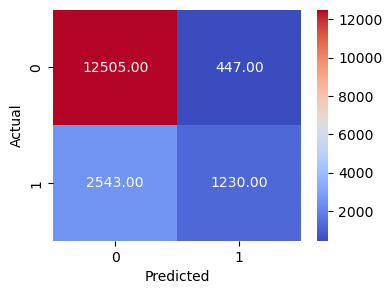

In [112]:
# Make predictions on the test set
predictions = gbc.predict(X_test)
calculate_metrics(y_test, predictions)
print('Custom model quality evaluation: ', custom_metric(predictions, X_test, X_test_full))
plot_confusion_matrix(y_test, predictions)

The model cuurently does not seem to be very promising, but we will try to improve it in the next steps.

##### Optimize Hyperparameters #####

In [113]:
param_grid = {
    'n_estimators': [50, 100, 200, 300, 400],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [2, 3, 4, 5]
}

# create new classifier
gbc = GradientBoostingClassifier(random_state=42)

# perform grid search
grid_search_cv = GridSearchCV(gbc, param_grid, cv=5)
grid_search_cv.fit(X_train, y_train)

print("Best params: ", grid_search_cv.best_params_)
print("Best score: ", grid_search_cv.best_score_)

best_params = grid_search_cv.best_params_

Now, we again retrain the model based on the tuned hyperparameters and check the performance of the model on the test set

In [ ]:
gbc = GradientBoostingClassifier(random_state=42, **best_params)
gbc.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.3, max_depth=5, n_estimators=400,
                           random_state=42)

Accuracy:  0.8662481315396113
Precision:  0.7924600152322925
Recall:  0.5515504903260006
F1:  0.6504141272073762
ROC AUC:  0.7547360234211843
Custom model quality evaluation:  -4113.16


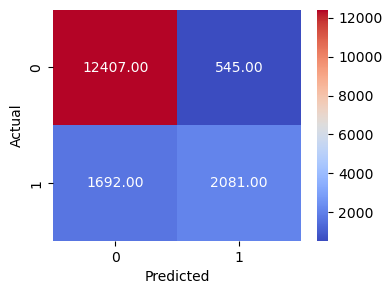

In [ ]:
# Make predictions on the test set
predictions = gbc.predict(X_test)
calculate_metrics(y_test, predictions)
print('Custom model quality evaluation: ', custom_metric(predictions, X_test, X_test_full))
plot_confusion_matrix(y_test, predictions)

After the hyperparameter tuning, the model seems to have improved, especially the FNs has decreased.

## Make Predictions ##

Now that we have tried out different models, we have to decide, which model we use to predict on the test_set.csv file for evaluation purposes.

Just to shortly recap: we trained 4 different models/classifiers: *decision tree*, *random forest*, *xgboost* and *gradient boosting*<br>
We found out, that some of them perform better than others.

If we compare the metrics for the predictions of each model, we can see some differences. 


Based on those results, we will select the **xgboost model** for the prediction on the test_set.csv file. This model may not have the greatest score for the custom model quality evaluation function, but it has an reletively high score for this function and it has the highest score for other evaluation scores. The f1 score, which is an important indicator like we earlier find out, of how well the model performs for the custom metric, is with 0.76 quite high. The Precision and recall are both relatively high, especially the precision. This is also good for the custom metric, because we found out in the sensitivity analysis that the metric is more sensitive for false positives than for false negatives.

## Sources ##

[1] Schulferien.org (2019). School Holidays 2019 in Germany, Available at: https://www.schulferien.org/deutschland/ferien/2019/ (Accessed: 10 July 2023).

[2] World-schools.com (2019). School holidays 2019 in the UK', Available at: https://world-schools.com/de/school-holidays-in-the-uk-in-2019/ (Accessed: 10 July 2023).

[3] Spott, Prof. Dr. Martin (2023). model_quality_balance_python. Provided by Prof. Spott. (2023)

[4] Spott, Prof. Dr. Martin (2023). train_set. Provided by Prof. Spott. (2023)

[5] Spott, Prof. Dr. Martin (2023). test_set. Provided by Prof. Spott. (2023)